# Loading Packages

In [1]:
!pip install -q lightgbm gpboost shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 35.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gpboost as gpb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, GroupKFold, ParameterGrid, ParameterSampler
)
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
)
import shap
import time
import random

# Set style
plt.style.use('ggplot')
%matplotlib inline

# View max columns
pd.set_option('display.max_columns', None)

# Reading in the Data

In [3]:
# Read in the data
data = pd.read_csv('centered_data_unscaled.csv')

# View the data
data.head()

PWS_ID OWNER_TYPE  YEAR_FULL   COUNTY PWS_TYPE  POPULATION  SERV_CON  \
0  CA0103040    Private       2013  Alameda      CWS       100.0        19   
1  CA0103040    Private       2014  Alameda      CWS       100.0        19   
2  CA0103040    Private       2015  Alameda      CWS       100.0        19   
3  CA0103040    Private       2016  Alameda      CWS       100.0        19   
4  CA0103040    Private       2017  Alameda      CWS        50.0        19   

  SOURCE WHOLESALER  FACILITIES  VIOLATIONS  SITE_VISITS  MED_INCOME  \
0     GW         No          16           2            4       72112   
1     GW         No           8           2            5       73775   
2     GW         No           8           2            5       75619   
3     GW         No           8           2            5       79831   
4     GW         No           8          54            5       85743   

   POV_RATE  AVG_PRECIP  AVG_TEMP  PERCENT_REP  PERCENT_DEM  PERCENT_OTH  \
0     0.125        5.08      59.5       0.1405       0.5643       0.2952   
1     0.129       19.88      62.0       0.1372       0.5606       0.3022   
2     0.125       10.39      61.1       0.1336       0.5523       0.3141   
3     0.120       22.55      60.4       0.1297       0.5626       0.3077   
4     0.113       24.97      60.5       0.1207       0.5760       0.3033   

   YEAR_FAC  YEAR  YEAR_C  POPULATION_L2  FACILITIES_L2  POPULATION_L3  \
0      2013     1       0           70.0            8.8  102437.828571   
1      2014     2       1           70.0            8.8  102437.828571   
2      2015     3       2           70.0            8.8  102437.828571   
3      2016     4       3           70.0            8.8  102437.828571   
4      2017     5       4           70.0            8.8  102437.828571   

   FACILITIES_L3  POPULATION_CWC1  FACILITIES_CWC1  POPULATION_CWC2  \
0      13.090476             30.0              7.2   -102367.828571   
1      13.090476             30.0             -0.8   -102367.828571   
2      13.090476             30.0             -0.8   -102367.828571   
3      13.090476             30.0             -0.8   -102367.828571   
4      13.090476            -20.0             -0.8   -102367.828571   

   FACILITIES_CWC2  POPULATION_L2_CGM  FACILITIES_L2_CGM  POPULATION_L3_CGM  \
0        -4.290476       -6293.809825          -0.146563       96074.018747   
1        -4.290476       -6293.809825          -0.146563       96074.018747   
2        -4.290476       -6293.809825          -0.146563       96074.018747   
3        -4.290476       -6293.809825          -0.146563       96074.018747   
4        -4.290476       -6293.809825          -0.146563       96074.018747   

   FACILITIES_L3_CGM  POV_RATE_CGM  AVG_PRECIP_CGM  AVG_TEMP_CGM  \
0           4.143913     -0.032842      -16.049184     -0.591134   
1           4.143913     -0.028842       -1.249184      1.908866   
2           4.143913     -0.032842      -10.739184      1.008866   
3           4.143913     -0.037842        1.420816      0.308866   
4           4.143913     -0.044842        3.840816      0.408866   

   PERCENT_REP_CGM  OWNER_TYPE_D1  OWNER_TYPE_D2  PWS_TYPE_D1  PWS_TYPE_D2  \
0        -0.179827              1              0            0            0   
1        -0.183127              1              0            0            0   
2        -0.186727              1              0            0            0   
3        -0.190627              1              0            0            0   
4        -0.199627              1              0            0            0   

   SOURCE_D1  SOURCE_D2  WHOLESALER_D1  OWNER_TYPE_D1_L2  OWNER_TYPE_D2_L2  \
0          0          0              0               1.0               0.0   
1          0          0              0               1.0               0.0   
2          0          0              0               1.0               0.0   
3          0          0              0               1.0               0.0   
4          0          0         

In [4]:
# View datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66770 entries, 0 to 66769
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PWS_ID                66770 non-null  object 
 1   OWNER_TYPE            66770 non-null  object 
 2   YEAR_FULL             66770 non-null  int64  
 3   COUNTY                66770 non-null  object 
 4   PWS_TYPE              66770 non-null  object 
 5   POPULATION            66770 non-null  float64
 6   SERV_CON              66770 non-null  int64  
 7   SOURCE                66770 non-null  object 
 8   WHOLESALER            66770 non-null  object 
 9   FACILITIES            66770 non-null  int64  
 10  VIOLATIONS            66770 non-null  int64  
 11  SITE_VISITS           66770 non-null  int64  
 12  MED_INCOME            66770 non-null  int64  
 13  POV_RATE              66770 non-null  float64
 14  AVG_PRECIP            66770 non-null  float64
 15  AVG_TEMP           

In [5]:
# Check for missing values
data.isnull().sum().sum()

0

In [6]:
# Define the predictor variables
pred_vars = [
    'YEAR_C',
    'POPULATION_CWC1', 'FACILITIES_CWC1',
    'POPULATION_CWC2', 'FACILITIES_CWC2',
    'POPULATION_L3_CGM', 'FACILITIES_L3_CGM',
    'OWNER_TYPE_D1_CWC1', 'OWNER_TYPE_D2_CWC1',
    'OWNER_TYPE_D1_CWC2', 'OWNER_TYPE_D2_CWC2',
    'OWNER_TYPE_D1_L3_CGM', 'OWNER_TYPE_D2_L3_CGM',
    'PWS_TYPE_D1_CWC1', 'PWS_TYPE_D2_CWC1',
    'PWS_TYPE_D1_CWC2', 'PWS_TYPE_D2_CWC2',
    'PWS_TYPE_D1_L3_CGM', 'PWS_TYPE_D2_L3_CGM',
    'SOURCE_D1_CWC1', 'SOURCE_D2_CWC1',
    'SOURCE_D1_CWC2', 'SOURCE_D2_CWC2',
    'SOURCE_D1_L3_CGM', 'SOURCE_D2_L3_CGM',
    'WHOLESALER_D1_CWC1',
    'WHOLESALER_D1_CWC2',
    'WHOLESALER_D1_L3_CGM',
    'POV_RATE_CGM', 'PERCENT_REP_CGM', 'AVG_PRECIP_CGM', 'AVG_TEMP_CGM'
]

print(f'Predictor Variables:\n{pred_vars}')

Predictor Variables:
['YEAR_C', 'POPULATION_CWC1', 'FACILITIES_CWC1', 'POPULATION_CWC2', 'FACILITIES_CWC2', 'POPULATION_L3_CGM', 'FACILITIES_L3_CGM', 'OWNER_TYPE_D1_CWC1', 'OWNER_TYPE_D2_CWC1', 'OWNER_TYPE_D1_CWC2', 'OWNER_TYPE_D2_CWC2', 'OWNER_TYPE_D1_L3_CGM', 'OWNER_TYPE_D2_L3_CGM', 'PWS_TYPE_D1_CWC1', 'PWS_TYPE_D2_CWC1', 'PWS_TYPE_D1_CWC2', 'PWS_TYPE_D2_CWC2', 'PWS_TYPE_D1_L3_CGM', 'PWS_TYPE_D2_L3_CGM', 'SOURCE_D1_CWC1', 'SOURCE_D2_CWC1', 'SOURCE_D1_CWC2', 'SOURCE_D2_CWC2', 'SOURCE_D1_L3_CGM', 'SOURCE_D2_L3_CGM', 'WHOLESALER_D1_CWC1', 'WHOLESALER_D1_CWC2', 'WHOLESALER_D1_L3_CGM', 'POV_RATE_CGM', 'PERCENT_REP_CGM', 'AVG_PRECIP_CGM', 'AVG_TEMP_CGM']


In [7]:
# Define the random effects grouping variables
group_vars = ['PWS_ID', 'COUNTY']
print(f'Grouping Variables:\n{group_vars}')

Grouping Variables:
['PWS_ID', 'COUNTY']


In [8]:
# Filter the data
data = data[pred_vars + group_vars + ['VIOLATIONS']]
data.head()

YEAR_C  POPULATION_CWC1  FACILITIES_CWC1  POPULATION_CWC2  FACILITIES_CWC2  \
0       0             30.0              7.2   -102367.828571        -4.290476   
1       1             30.0             -0.8   -102367.828571        -4.290476   
2       2             30.0             -0.8   -102367.828571        -4.290476   
3       3             30.0             -0.8   -102367.828571        -4.290476   
4       4            -20.0             -0.8   -102367.828571        -4.290476   

   POPULATION_L3_CGM  FACILITIES_L3_CGM  OWNER_TYPE_D1_CWC1  \
0       96074.018747           4.143913                 0.0   
1       96074.018747           4.143913                 0.0   
2       96074.018747           4.143913                 0.0   
3       96074.018747           4.143913                 0.0   
4       96074.018747           4.143913                 0.0   

   OWNER_TYPE_D2_CWC1  OWNER_TYPE_D1_CWC2  OWNER_TYPE_D2_CWC2  \
0                 0.0            0.795238           -0.080952   
1                 0.0            0.795238           -0.080952   
2                 0.0            0.795238           -0.080952   
3                 0.0            0.795238           -0.080952   
4                 0.0            0.795238           -0.080952   

   OWNER_TYPE_D1_L3_CGM  OWNER_TYPE_D2_L3_CGM  PWS_TYPE_D1_CWC1  \
0             -0.446623              0.068192               0.0   
1             -0.446623              0.068192               0.0   
2             -0.446623              0.068192               0.0   
3             -0.446623              0.068192               0.0   
4             -0.446623              0.068192               0.0   

   PWS_TYPE_D2_CWC1  PWS_TYPE_D1_CWC2  PWS_TYPE_D2_CWC2  PWS_TYPE_D1_L3_CGM  \
0               0.0         -0.095238         -0.238095            -0.09621   
1               0.0         -0.095238         -0.238095            -0.09621   
2               0.0         -0.095238         -0.238095            -0.09621   
3               0.0         -0.095238         -0.238095            -0.09621   
4               0.0         -0.095238         -0.238095            -0.09621   

   PWS_TYPE_D2_L3_CGM  SOURCE_D1_CWC1  SOURCE_D2_CWC1  SOURCE_D1_CWC2  \
0           -0.149414             0.0             0.0       -0.571429   
1           -0.149414             0.0             0.0       -0.571429   
2           -0.149414             0.0             0.0       -0.571429   
3           -0.149414             0.0             0.0       -0.571429   
4           -0.149414             0.0             0.0       -0.571429   

   SOURCE_D2_CWC2  SOURCE_D1_L3_CGM  SOURCE_D2_L3_CGM  WHOLESALER_D1_CWC1  \
0             0.0          0.420942         -0.015786                 0.0   
1             0.0          0.420942         -0.015786                 0.0   
2             0.0          0.420942         -0.015786                 0.0   
3             0.0          0.420942         -0.015786                 0.0   
4             0.0          0.420942         -0.015786                 0.0   

   WHOLESALER_D1_CWC2  WHOLESALER_D1_L3_CGM  POV_RATE_CGM  PERCENT_REP_CGM  \
0           -0.133333              0.119884     -0.032842        -0.179827   
1           -0.133333              0.119884     -0.028842        -0.183127   
2           -0.133333              0.119884     -0.032842        -0.186727   
3           -0.133333              0.119884     -0.037842        -0.190627   
4           -0.133333              0.119884     -0.044842        -0.199627   

   AVG_PRECIP_CGM  AVG_TEMP_CGM     PWS_ID   COUNTY  VIOLATIONS  
0      -16.049184     -0.591134  CA0103040  Alameda           2  
1       -1.249184      1.908866  CA0103040  Alameda           2  
2      -10.739184      1.008866  CA0103040  Alameda           2  
3        1.420816      0.308866  CA0103040  Alameda           2  
4        3.840816      0.408866  CA0103040  Alameda          54

# Preparing the Data

## Split the Data

In [9]:
# Define features and label
X = data.drop(['VIOLATIONS'], axis=1)
y = data['VIOLATIONS']

# View the features
X.head()

YEAR_C  POPULATION_CWC1  FACILITIES_CWC1  POPULATION_CWC2  FACILITIES_CWC2  \
0       0             30.0              7.2   -102367.828571        -4.290476   
1       1             30.0             -0.8   -102367.828571        -4.290476   
2       2             30.0             -0.8   -102367.828571        -4.290476   
3       3             30.0             -0.8   -102367.828571        -4.290476   
4       4            -20.0             -0.8   -102367.828571        -4.290476   

   POPULATION_L3_CGM  FACILITIES_L3_CGM  OWNER_TYPE_D1_CWC1  \
0       96074.018747           4.143913                 0.0   
1       96074.018747           4.143913                 0.0   
2       96074.018747           4.143913                 0.0   
3       96074.018747           4.143913                 0.0   
4       96074.018747           4.143913                 0.0   

   OWNER_TYPE_D2_CWC1  OWNER_TYPE_D1_CWC2  OWNER_TYPE_D2_CWC2  \
0                 0.0            0.795238           -0.080952   
1                 0.0            0.795238           -0.080952   
2                 0.0            0.795238           -0.080952   
3                 0.0            0.795238           -0.080952   
4                 0.0            0.795238           -0.080952   

   OWNER_TYPE_D1_L3_CGM  OWNER_TYPE_D2_L3_CGM  PWS_TYPE_D1_CWC1  \
0             -0.446623              0.068192               0.0   
1             -0.446623              0.068192               0.0   
2             -0.446623              0.068192               0.0   
3             -0.446623              0.068192               0.0   
4             -0.446623              0.068192               0.0   

   PWS_TYPE_D2_CWC1  PWS_TYPE_D1_CWC2  PWS_TYPE_D2_CWC2  PWS_TYPE_D1_L3_CGM  \
0               0.0         -0.095238         -0.238095            -0.09621   
1               0.0         -0.095238         -0.238095            -0.09621   
2               0.0         -0.095238         -0.238095            -0.09621   
3               0.0         -0.095238         -0.238095            -0.09621   
4               0.0         -0.095238         -0.238095            -0.09621   

   PWS_TYPE_D2_L3_CGM  SOURCE_D1_CWC1  SOURCE_D2_CWC1  SOURCE_D1_CWC2  \
0           -0.149414             0.0             0.0       -0.571429   
1           -0.149414             0.0             0.0       -0.571429   
2           -0.149414             0.0             0.0       -0.571429   
3           -0.149414             0.0             0.0       -0.571429   
4           -0.149414             0.0             0.0       -0.571429   

   SOURCE_D2_CWC2  SOURCE_D1_L3_CGM  SOURCE_D2_L3_CGM  WHOLESALER_D1_CWC1  \
0             0.0          0.420942         -0.015786                 0.0   
1             0.0          0.420942         -0.015786                 0.0   
2             0.0          0.420942         -0.015786                 0.0   
3             0.0          0.420942         -0.015786                 0.0   
4             0.0          0.420942         -0.015786                 0.0   

   WHOLESALER_D1_CWC2  WHOLESALER_D1_L3_CGM  POV_RATE_CGM  PERCENT_REP_CGM  \
0           -0.133333              0.119884     -0.032842        -0.179827   
1           -0.133333              0.119884     -0.028842        -0.183127   
2           -0.133333              0.119884     -0.032842        -0.186727   
3           -0.133333              0.119884     -0.037842        -0.190627   
4           -0.133333              0.119884     -0.044842        -0.199627   

   AVG_PRECIP_CGM  AVG_TEMP_CGM     PWS_ID   COUNTY  
0      -16.049184     -0.591134  CA0103040  Alameda  
1       -1.249184      1.908866  CA0103040  Alameda  
2      -10.739184      1.008866  CA0103040  Alameda  
3        1.420816      0.308866  CA0103040  Alameda  
4        3.840816      0.408866  CA0103040  Alameda

In [10]:
# Get unique water systems (pws_id)
unique_pws_ids = data['PWS_ID'].unique()

# Split the unique water systems into training, validation, and test sets
train_pws_ids, test_val_pws_ids = train_test_split(unique_pws_ids, test_size=0.2, random_state=42)
test_pws_ids, val_pws_ids = train_test_split(test_val_pws_ids, test_size=0.5, random_state=42)

# Select the corresponding data for each split
X_train = X[X['PWS_ID'].isin(train_pws_ids)]
X_val = X[X['PWS_ID'].isin(val_pws_ids)]
X_test = X[X['PWS_ID'].isin(test_pws_ids)]
y_train = y[data['PWS_ID'].isin(train_pws_ids)]
y_val = y[data['PWS_ID'].isin(val_pws_ids)]
y_test = y[data['PWS_ID'].isin(test_pws_ids)]

In [11]:
# Print the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print("\n")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (53410, 34)
X_val shape: (6680, 34)
X_test shape: (6680, 34)


y_train shape: (53410,)
y_val shape: (6680,)
y_test shape: (6680,)


In [12]:
# Check entity-level consistency for each split
def check_entity_level_consistency(data1, data2):
    overlap_pws_ids = np.intersect1d(data1['PWS_ID'].unique(), data2['PWS_ID'].unique())
    if len(overlap_pws_ids) == 0:
        print("Entity-level consistency maintained. No overlap found.")
    else:
        print(f"Warning: Entity-level consistency violated. {len(overlap_pws_ids)} water systems appear in both sets.")

print("Checking consistency between training and validation sets:")
check_entity_level_consistency(X_train, X_val)
print("\nChecking consistency between training and test sets:")
check_entity_level_consistency(X_train, X_test)
print("\nChecking consistency between validation and test sets:")
check_entity_level_consistency(X_val, X_test)

Checking consistency between training and validation sets:
Entity-level consistency maintained. No overlap found.

Checking consistency between training and test sets:
Entity-level consistency maintained. No overlap found.

Checking consistency between validation and test sets:
Entity-level consistency maintained. No overlap found.


## Subset if Testing

In [13]:
# # Subset testing
# subset_testing = False

# if subset_testing:
#     subset_fraction = 0.01
#     X_train = X_train.sample(frac=subset_fraction, random_state=42)
#     y_train = y_train.loc[X_train.index]
#     X_val = X_val.sample(frac=subset_fraction, random_state=42)
#     y_val = y_val.loc[X_val.index]
#     X_test = X_test.sample(frac=subset_fraction, random_state=42)
#     y_test = y_test.loc[X_test.index]

#     print("Checking consistency between training and validation sets:")
#     check_entity_level_consistency(X_train, X_val)
#     print("\nChecking consistency between training and test sets:")
#     check_entity_level_consistency(X_train, X_test)
#     print("\nChecking consistency between validation and test sets:")
#     check_entity_level_consistency(X_val, X_test)

In [14]:
# # Size of the subsets
# if subset_testing:
#     print(f"X_train shape: {X_train.shape}")
#     print(f"X_val shape: {X_val.shape}")
#     print(f"X_test shape: {X_test.shape}")
#     print("\n")
#     print(f"y_train shape: {y_train.shape}")
#     print(f"y_val shape: {y_val.shape}")
#     print(f"y_test shape: {y_test.shape}")

# Training the Model

## Datasets

In [15]:
# Create GPBoost training dataset
train_dataset = gpb.Dataset(
    data=X_train[pred_vars],
    label=y_train
)

# Create GPBoost validation dataset
val_dataset = gpb.Dataset(
    data=X_val[pred_vars],
    label=y_val,
    reference=train_dataset
)

## GP Model

In [16]:
# Define the mixed effects model
gp_model = gpb.GPModel(
    group_data=X_train[group_vars],
    likelihood='negative_binomial',
    seed=42
)

In [17]:
# Set the optimizer
gp_model.set_optim_params(params={
    'optimizer_cov': 'nelder_mead',
    'trace': True
})

In [18]:
# Set validation prediction data for the model
gp_model.set_prediction_data(
    group_data_pred=X_val[group_vars]
)

## Training

In [19]:
# Set parameters dictionary
params = {
    'early_stopping_rounds': 50
}

In [20]:
# Start timer
start_time = time.time()

# Train GPBoost model
gpboost_model = gpb.train(
    params=params,
    train_set=train_dataset,
    gp_model=gp_model,
    valid_sets=[val_dataset],
    valid_names=['val'],
    verbose_eval=10
)

# Print best iteration and score
print(f"Best iteration: {gpboost_model.best_iteration}")
print(f"Best score: {gpboost_model.best_score}")

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

/usr/local/lib/python3.10/dist-packages/gpboost/engine.py:192: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[GPBoost] [Info] Total Bins 3649
[GPBoost] [Info] Number of data points in the train set: 53410, number of used features: 32
[GPBoost] [Debug] 

[GPBoost] [Debug] GPModel: start finding initial intercept ... 
[GPBoost] [Debug] GPModel: initial parameters: 
[GPBoost] [Debug] cov_pars[0]: 0.1
[GPBoost] [Debug] cov_pars[1]: 0.1
[GPBoost] [Debug] beta[0]: 2.1852
[GPBoost] [Debug] shape: 0.594919
[GPBoost] [Debug] Initial approximate negative marginal log-likelihood: 171106
[GPBoost] [Debug] GPModel: parameters after optimization iteration number 1: 
[GPBoost] [Debug] beta[0]: 1.85742
[GPBoost] [Debug] Approximate negative marginal log-likelihood: 171067
[GPBoost] [Debug] GPModel: parameters after optimization iteration number 2: 
[GPBoost] [Debug] beta[0]: 1.77548
[GPBoost] [Debug] Approximate negative marginal log-likelihood: 171066
[GPBoost] [Debug] GPModel: parameters after optimization iteration number 3: 
[GPBoost] [Debug] beta[0]: 1.79596
[GPBoost] [Debug] Approximate negative margin

## Save the Model

In [21]:
# Save the models
print("Saving the models...")
gp_model.save_model("gp_model.json")
gpboost_model.save_model("gpboost_model.json")
print("Saving complete.")

Saving the models...
Saving complete.


In [22]:
# # Load the models
# print("Loading the models...")
# gp_model = gpb.GPModel(model_file="gp_model.json")
# gpboost_model = gpb.Booster(model_file="gpboost_model.json")
# print("Loading complete.")

# Evaluating the Model

## Random Effects

In [23]:
# Get random effects
print("Model Summary:")
gp_model.summary()

Model Summary:
Covariance parameters (random effects):
        Param.
PWS_ID  1.8646
COUNTY  0.4414
-----------------------------------------------------
Additional parameters:
        Param.
shape  37.1333


## Metrics

In [24]:
# Get predictions on the test set
test_pred = gpboost_model.predict(
    data=X_test[pred_vars],
    group_data_pred=X_test[group_vars],
    predict_var=True
)

# Evaluate performance on the test set
test_rmse = np.sqrt(np.mean((y_test - test_pred['response_mean'])**2))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 14.1536


In [25]:
# Calculate metrics
test_mse = mean_squared_error(y_test, test_pred['response_mean'])
test_mae = mean_absolute_error(y_test, test_pred['response_mean'])

In [26]:
# Create a dictionary with the metrics
metrics_dict = {
    'Metric': ['RMSE', 'MSE', 'MAE'],
    'Value': [test_rmse, test_mse, test_mae]
}

# Create a dataframe from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Print the dataframe
print("Model Performance Metrics:")
metrics_df

Model Performance Metrics:


Metric       Value
0   RMSE   14.153571
1    MSE  200.323581
2    MAE   10.070231

## Residual Plots

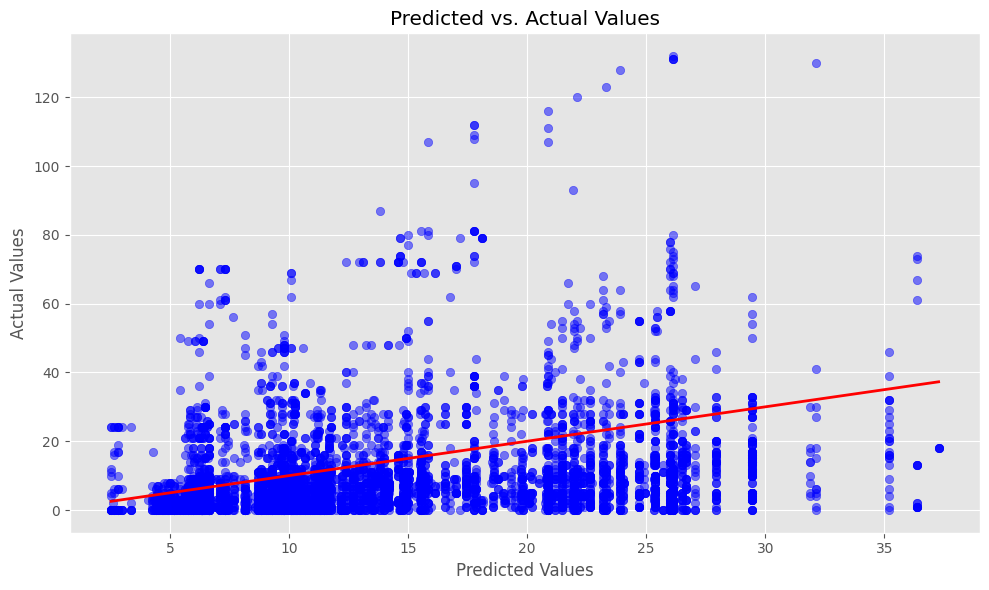

In [27]:
# Plot predictions vs. actual values
y_pred = test_pred['response_mean']
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, alpha=0.5, color='b')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='r', linestyle='-', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs. Actual Values')
plt.tight_layout()
plt.show()

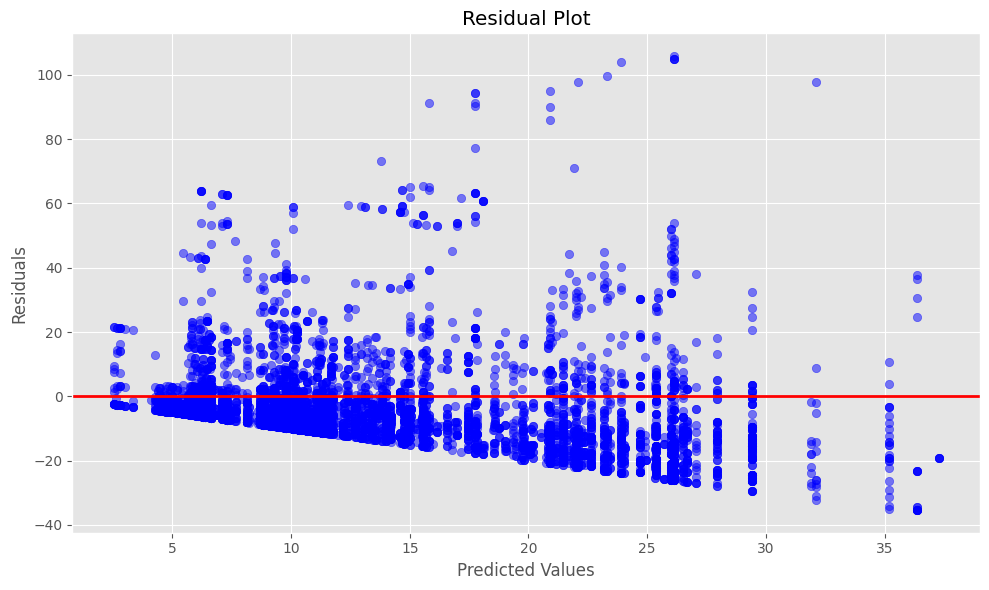

In [28]:
# Plot the residuals
y_pred = test_pred['response_mean']
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='b')
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

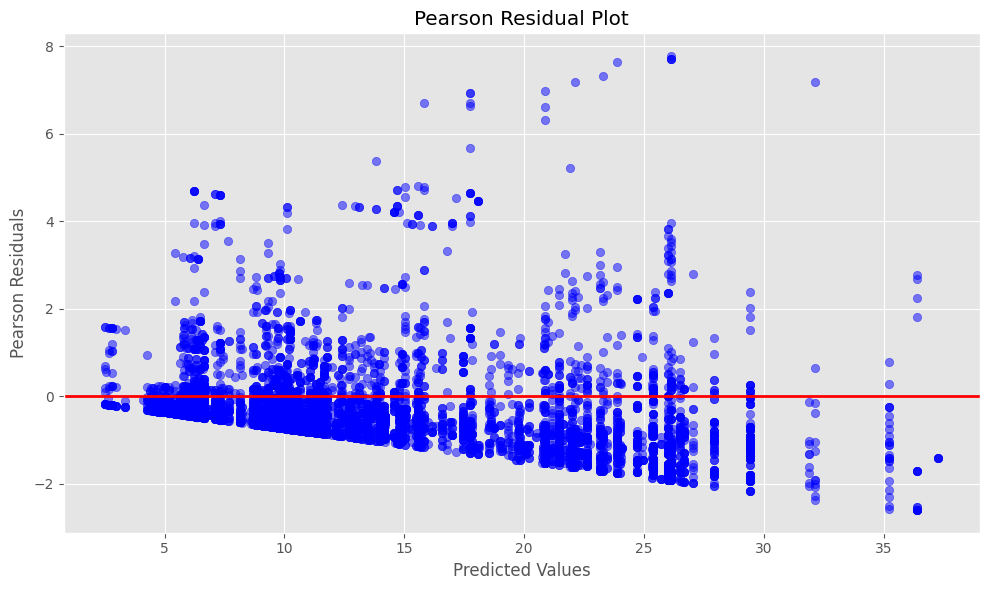

In [29]:
# Calculate raw residuals
raw_residuals = y_test - y_pred

# Calculate the standard deviation of the raw residuals
residual_std = np.std(raw_residuals)

# Calculate Pearson residuals
pearson_residuals = raw_residuals / residual_std

# Plot the Pearson residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, pearson_residuals, alpha=0.5, color='b')
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Pearson Residuals')
plt.title('Pearson Residual Plot')
plt.tight_layout()
plt.show()

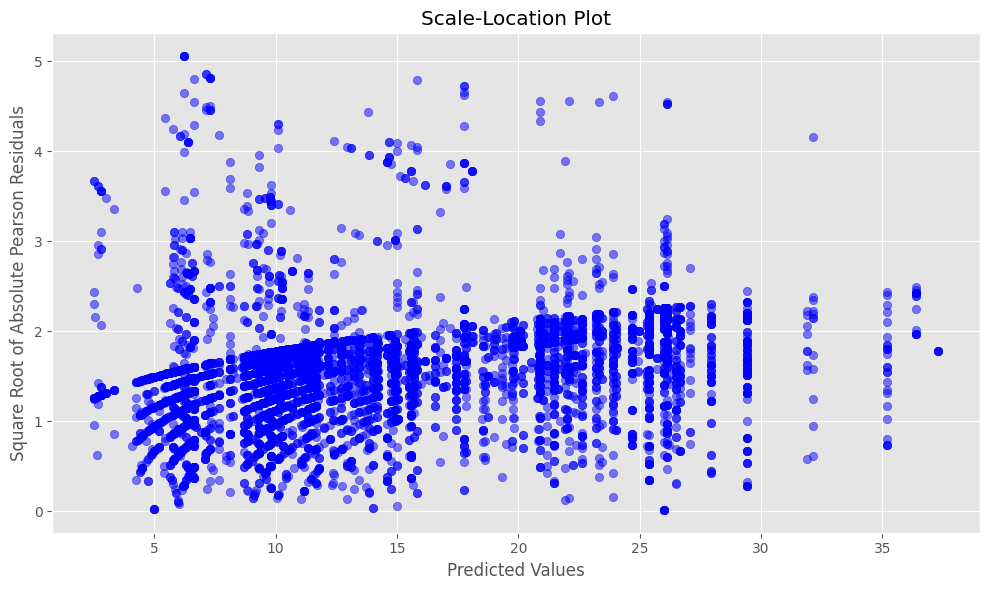

In [30]:
# Calculate raw residuals
raw_residuals = y_test - y_pred

# Calculate Pearson residuals
pearson_residuals = raw_residuals / np.sqrt(y_pred)

# Calculate the absolute values of Pearson residuals
abs_pearson_residuals = np.abs(pearson_residuals)

# Calculate the square root of the absolute values of Pearson residuals
sqrt_abs_pearson_residuals = np.sqrt(abs_pearson_residuals)

# Create the scale-location plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, sqrt_abs_pearson_residuals, alpha=0.5, color='b')
plt.xlabel('Predicted Values')
plt.ylabel('Square Root of Absolute Pearson Residuals')
plt.title('Scale-Location Plot')
plt.tight_layout()
plt.show()

## Feature Importance

In [31]:
# Define feature mapping
gpboost_feature_mapping = {
    'YEAR_C': "Year (Centered)",
    'POPULATION_CWC1': "Population (CWC-1)",
    'FACILITIES_CWC1': "Facilities (CWC-1)",
    'POPULATION_CWC2': "Population (CWC-2)",
    'FACILITIES_CWC2': "Facilities (CWC-2)",
    'POPULATION_L3_CGM': "Population (CGM-3)",
    'FACILITIES_L3_CGM': "Facilities (CGM-3)",
    'OWNER_TYPE_D1_CWC1': "Owner: Private (CWC-1)",
    'OWNER_TYPE_D2_CWC1': "Owner: PPP (CWC-1)",
    'OWNER_TYPE_D1_CWC2': "Owner: Private (CWC-2)",
    'OWNER_TYPE_D2_CWC2': "Owner: PPP (CWC-2)",
    'OWNER_TYPE_D1_L3_CGM': "Owner: Private (CGM-3)",
    'OWNER_TYPE_D2_L3_CGM': "Owner: PPP (CGM-3)",
    'PWS_TYPE_D1_CWC1': "Servicer: NTNCWS (CWC-1)",
    'PWS_TYPE_D2_CWC1': "Servicer: TNCWS (CWC-1)",
    'PWS_TYPE_D1_CWC2': "Servicer: NTNCWS (CWC-2)",
    'PWS_TYPE_D2_CWC2': "Servicer: TNCWS (CWC-2)",
    'PWS_TYPE_D1_L3_CGM': "Servicer: NTNCWS (CGM-3)",
    'PWS_TYPE_D2_L3_CGM': "Servicer: TNCWS (CGM-3)",
    'SOURCE_D1_CWC1': "Source: Surface (CWC-1)",
    'SOURCE_D2_CWC1': "Source: Unknown (CWC-1)",
    'SOURCE_D1_CWC2': "Source: Surface (CWC-2)",
    'SOURCE_D2_CWC2': "Source: Unknown (CWC-2)",
    'SOURCE_D1_L3_CGM': "Source: Surface (CGM-3)",
    'SOURCE_D2_L3_CGM': "Source: Unknown (CGM-3)",
    'WHOLESALER_D1_CWC1': "Wholesaler: Yes (CWC-1)",
    'WHOLESALER_D1_CWC2': "Wholesaler: Yes (CWC-2)",
    'WHOLESALER_D1_L3_CGM': "Wholesaler: Yes (CGM-3)",
    'POV_RATE_CGM': "Poverty Rate (CGM-3)",
    'PERCENT_REP_CGM': "Pct Republican (CGM-3)",
    'AVG_PRECIP_CGM': "Precipitation (CGM-3)",
    'AVG_TEMP_CGM': "Temperature (CGM-3)"
}

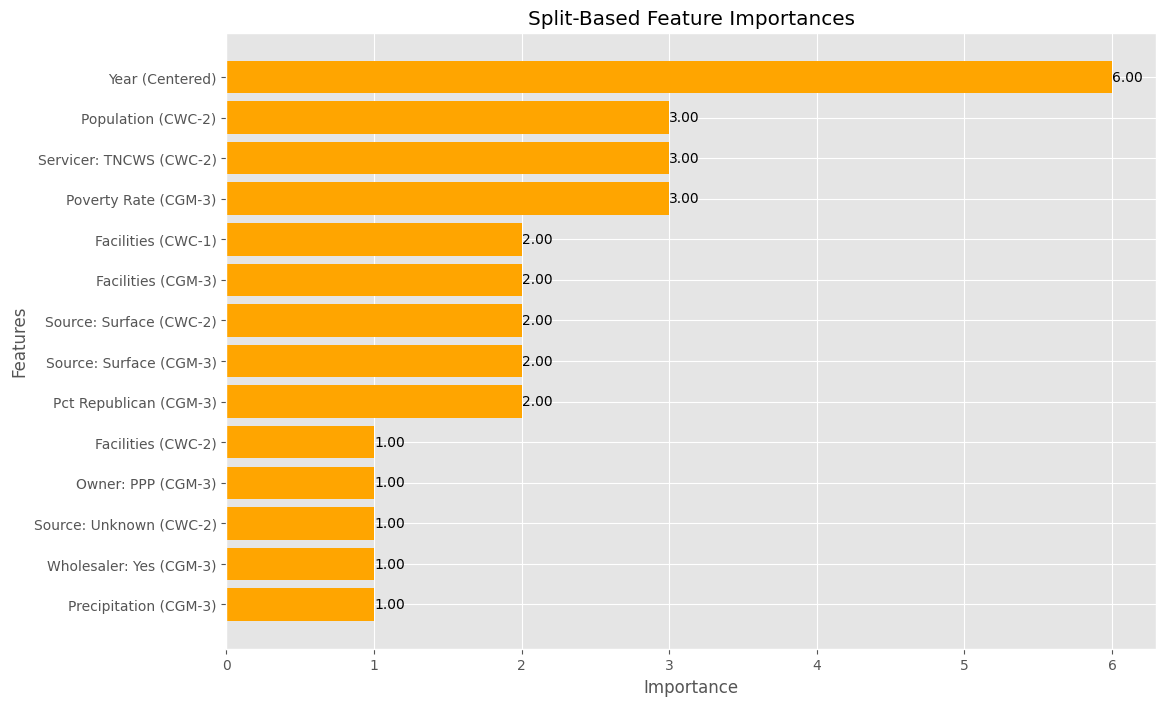

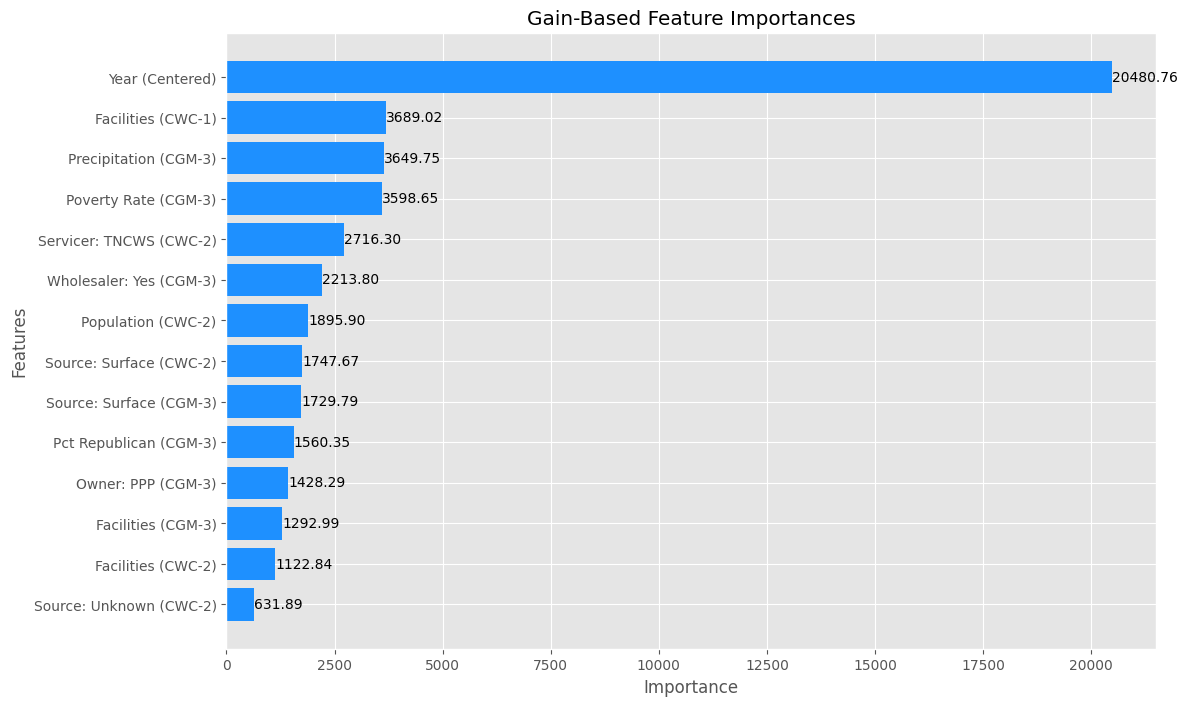

In [32]:
# Get the feature importances for split
split_importance_df = pd.DataFrame({
    'feature': gpboost_model.feature_name(),
    'importance': gpboost_model.feature_importance(importance_type='split')
})

# Filter out zero importance features
split_importance_df = split_importance_df[split_importance_df['importance'] > 0]

# Map the feature names
split_importance_df['mapped_feature'] = split_importance_df['feature'].map(gpboost_feature_mapping).fillna(split_importance_df['feature'])

# Sort by importance
split_importance_df = split_importance_df.sort_values(by='importance', ascending=False)

# Plot the sorted feature importances for split
plt.figure(figsize=(12, 8))
bars = plt.barh(split_importance_df['mapped_feature'], split_importance_df['importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Split-Based Feature Importances')
plt.gca().invert_yaxis()

# Add importance values to the bars
for bar in bars:
    plt.gca().text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}',
                   va='center', ha='left', color='black', fontsize=10)

plt.show()

# Get the feature importances for gain
gain_importance_df = pd.DataFrame({
    'feature': gpboost_model.feature_name(),
    'importance': gpboost_model.feature_importance(importance_type='gain')
})

# Filter out zero importance features
gain_importance_df = gain_importance_df[gain_importance_df['importance'] > 0]

# Map the feature names
gain_importance_df['mapped_feature'] = gain_importance_df['feature'].map(gpboost_feature_mapping).fillna(gain_importance_df['feature'])

# Sort by importance
gain_importance_df = gain_importance_df.sort_values(by='importance', ascending=False)

# Plot the sorted feature importances for gain
plt.figure(figsize=(12, 8))
bars = plt.barh(gain_importance_df['mapped_feature'], gain_importance_df['importance'], color='dodgerblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Gain-Based Feature Importances')
plt.gca().invert_yaxis()

# Add importance values to the bars
for bar in bars:
    plt.gca().text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}',
                   va='center', ha='left', color='black', fontsize=10)

plt.show()

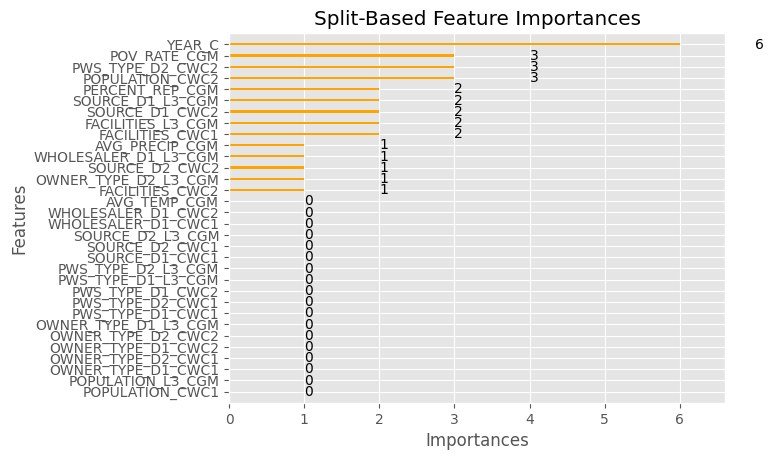

In [33]:
# Plot split-based feature importances
split_importance_plot = gpb.plot_importance(
    gpboost_model,
    importance_type='split',
    ignore_zero=False,
    title='Split-Based Feature Importances',
    ylabel='Features',
    xlabel='Importances',
    color='orange'
);

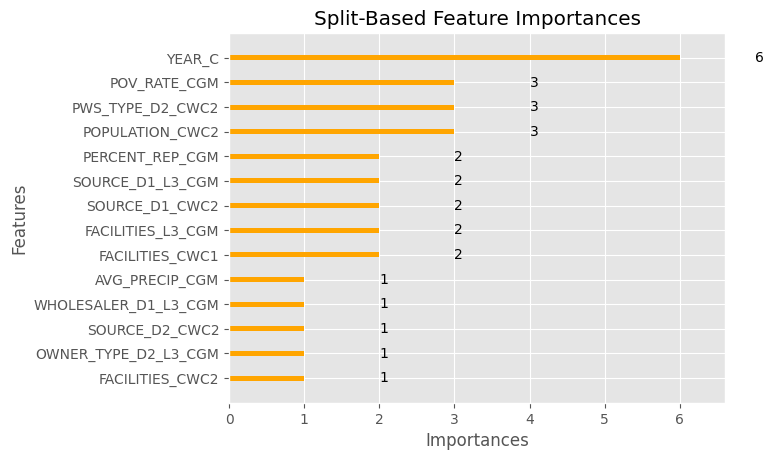

In [34]:
# Plot split-based feature importances
split_importance_plot = gpb.plot_importance(
    gpboost_model,
    importance_type='split',
    ignore_zero=True,
    title='Split-Based Feature Importances',
    ylabel='Features',
    xlabel='Importances',
    color='orange'
);

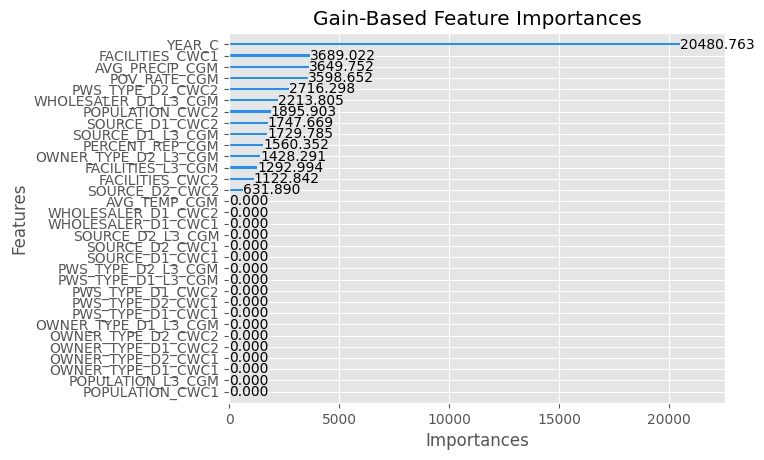

In [35]:
# Plot gain-based feature importances
split_importance_plot = gpb.plot_importance(
    gpboost_model,
    importance_type='gain',
    ignore_zero=False,
    title='Gain-Based Feature Importances',
    ylabel='Features',
    xlabel='Importances',
    color='dodgerblue'
);

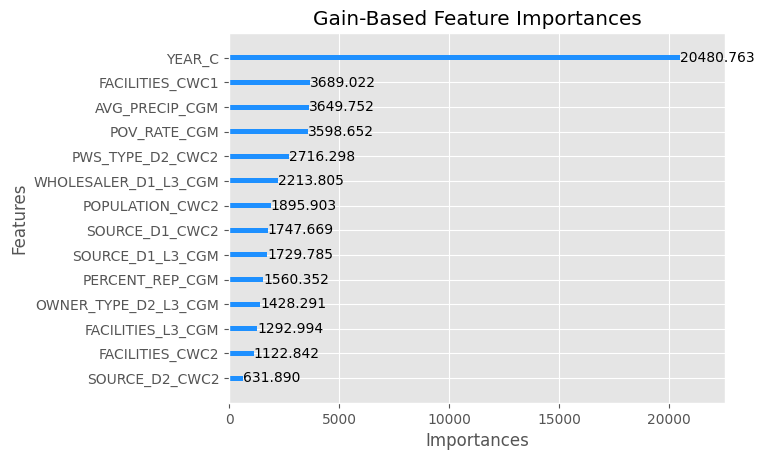

In [36]:
# Plot gain-based feature importances
split_importance_plot = gpb.plot_importance(
    gpboost_model,
    importance_type='gain',
    ignore_zero=True,
    title='Gain-Based Feature Importances',
    ylabel='Features',
    xlabel='Importances',
    color='dodgerblue'
);

## SHAP Plots

In [37]:
shap.initjs()

# Initialize an TreeExplainer object
tree_explainer = shap.TreeExplainer(
    model=gpboost_model,
    data=None,
    feature_perturbation='tree_path_dependent'
)

In [38]:
# Get SHAP values
shap_values_tree = tree_explainer.shap_values(X_test[pred_vars])

In [39]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values_tree).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test[pred_vars].columns,
    'Value': mean_abs_shap_values
})

# Sort the features
shap_importance = shap_importance.sort_values(by='Value', ascending=False)
shap_importance = shap_importance.reset_index(drop=True)
shap_importance

Feature     Value
0                 YEAR_C  0.055098
1         AVG_PRECIP_CGM  0.019038
2           POV_RATE_CGM  0.013432
3        FACILITIES_CWC1  0.009377
4   WHOLESALER_D1_L3_CGM  0.006334
5       SOURCE_D1_L3_CGM  0.003550
6        PERCENT_REP_CGM  0.003320
7      FACILITIES_L3_CGM  0.003262
8        FACILITIES_CWC2  0.003119
9   OWNER_TYPE_D2_L3_CGM  0.002918
10        SOURCE_D1_CWC2  0.002422
11      PWS_TYPE_D2_CWC2  0.002312
12       POPULATION_CWC2  0.001981
13        SOURCE_D2_CWC2  0.000785
14      PWS_TYPE_D1_CWC1  0.000000
15     POPULATION_L3_CGM  0.000000
16    OWNER_TYPE_D1_CWC1  0.000000
17    OWNER_TYPE_D2_CWC1  0.000000
18    WHOLESALER_D1_CWC2  0.000000
19    WHOLESALER_D1_CWC1  0.000000
20      SOURCE_D2_L3_CGM  0.000000
21    OWNER_TYPE_D1_CWC2  0.000000
22  OWNER_TYPE_D1_L3_CGM  0.000000
23    OWNER_TYPE_D2_CWC2  0.000000
24        SOURCE_D2_CWC1  0.000000
25        SOURCE_D1_CWC1  0.000000
26    PWS_TYPE_D2_L3_CGM  0.000000
27    PWS_TYPE_D1_L3_CGM  0.000000
28       POPULATION_CWC1  0.000000
29      PWS_TYPE_D1_CWC2  0.000000
30      PWS_TYPE_D2_CWC1  0.000000
31          AVG_TEMP_CGM  0.000000

Plot Type: Bar


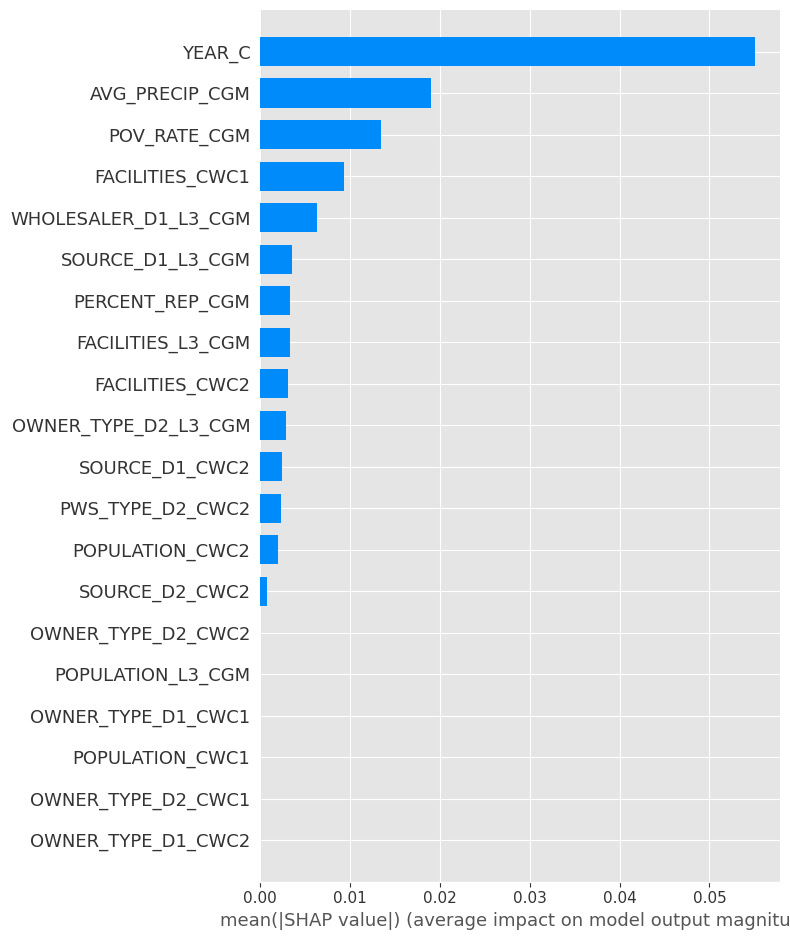

Plot Type: Dot


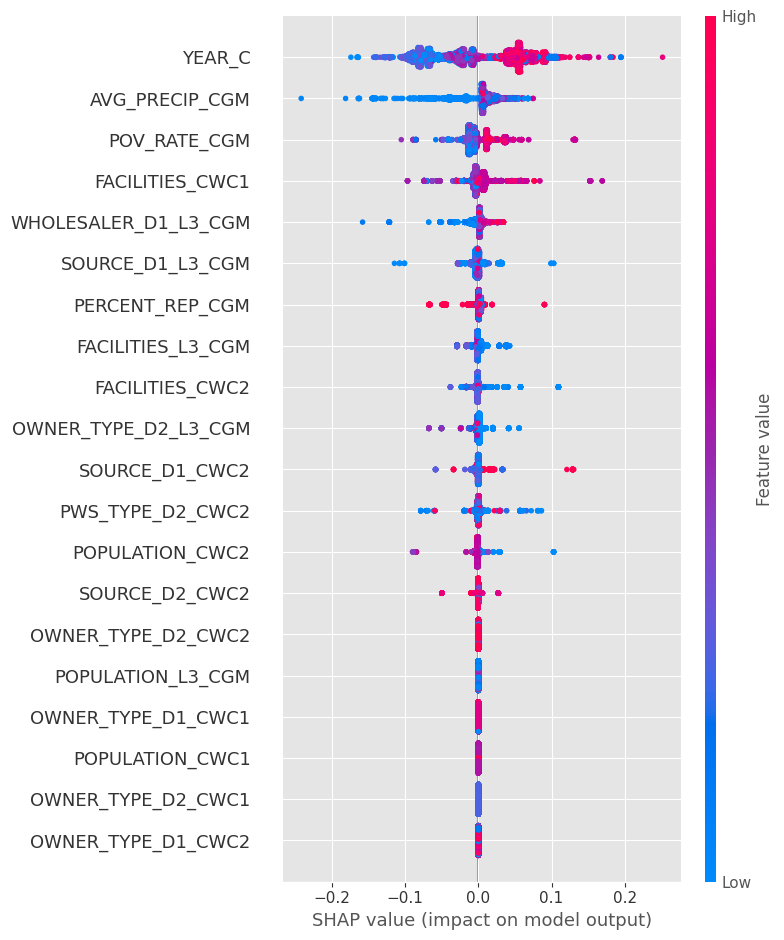

Plot Type: Violin


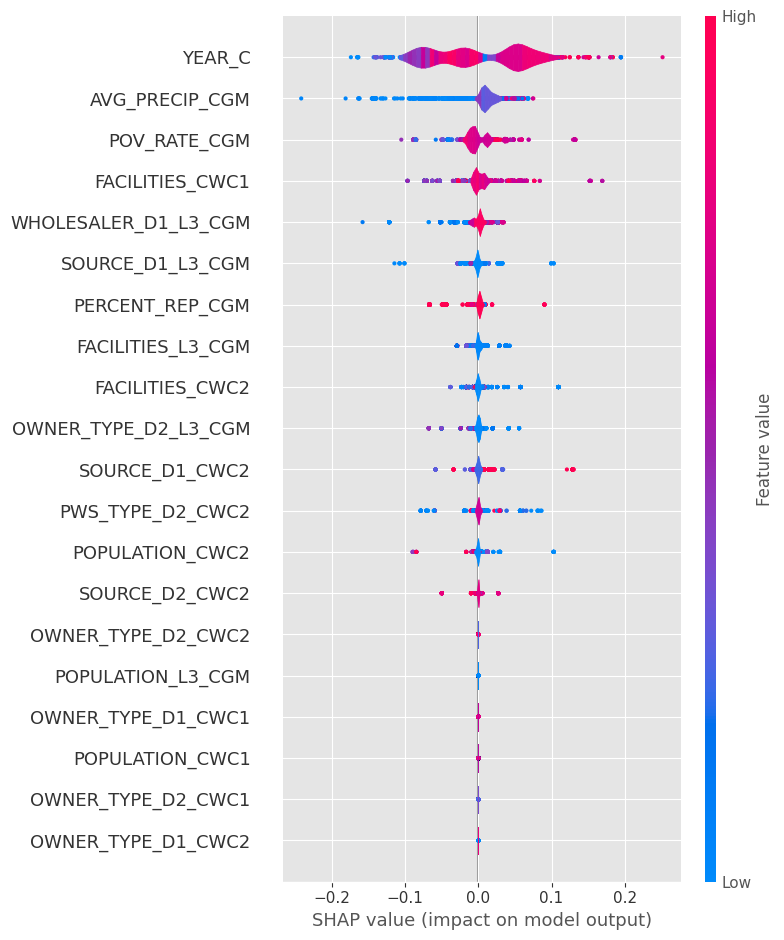

In [40]:
# Create summary plots
for plot_type in ['bar', 'dot', 'violin']:
    print(f"Plot Type: {plot_type.capitalize()}")
    shap.summary_plot(shap_values_tree, X_test[pred_vars], plot_type=plot_type)

Interaction Plot:


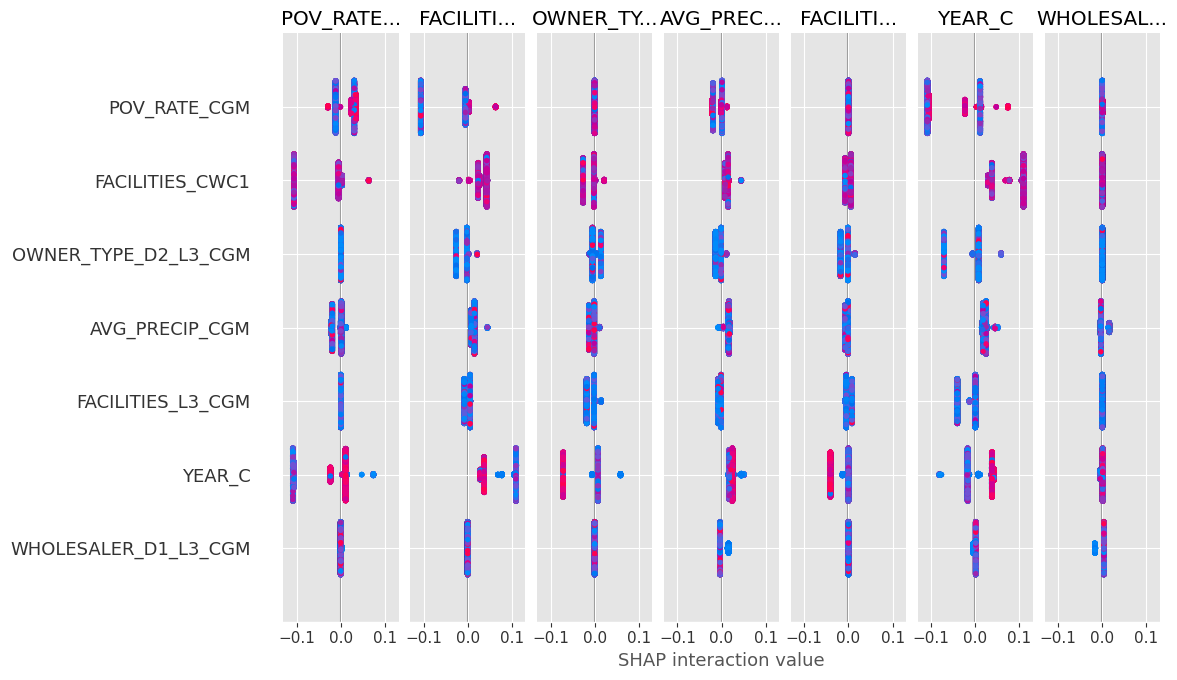

In [41]:
# Get SHAP interaction values
shap_interaction_values_tree = shap.TreeExplainer(gpboost_model).shap_interaction_values(shap_values_tree)

# Create summary plot
print(f"Interaction Plot:")
shap.summary_plot(shap_interaction_values_tree, X_test[pred_vars], plot_type=plot_type)

Decision Plot:


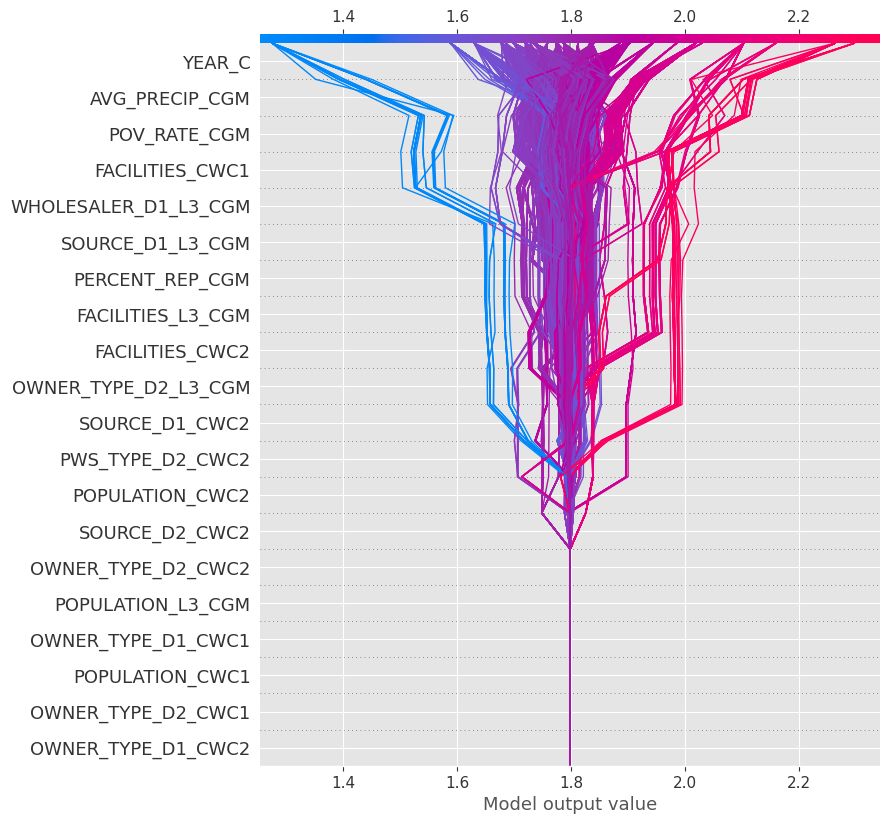

In [42]:
# Create decision plot
expected_value = tree_explainer.expected_value
features_display = X_test[pred_vars].columns
print(f"Decision Plot:")
shap.decision_plot(expected_value, shap_values_tree, features_display, ignore_warnings=True)

Interaction Decision Plot:


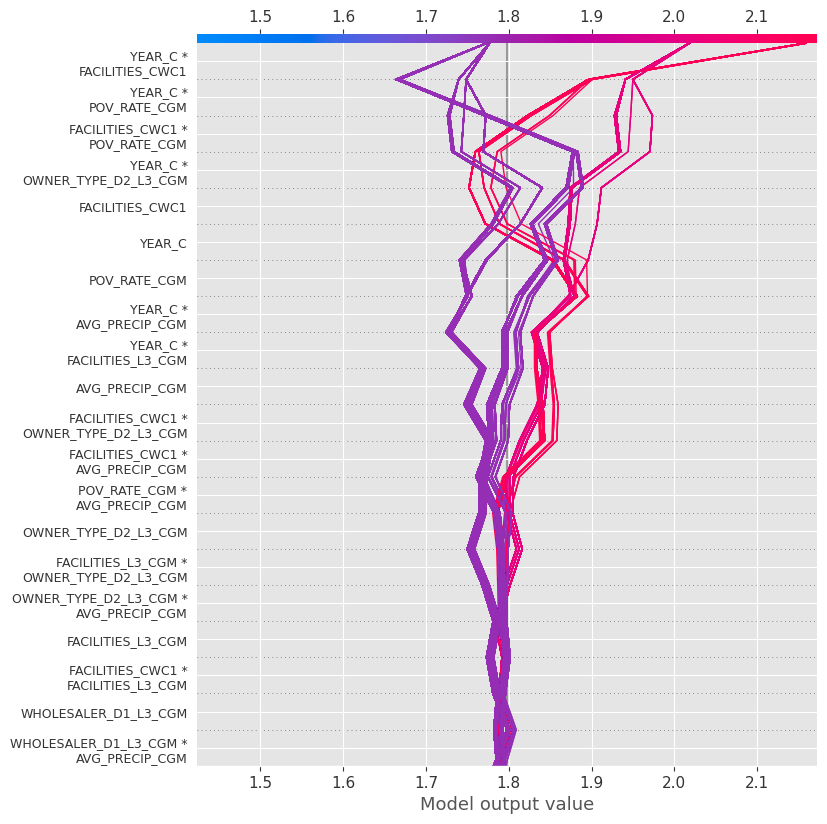

In [43]:
# Create interaction decision plot
expected_value = tree_explainer.expected_value
features_display = X_test[pred_vars].columns
print(f"Interaction Decision Plot:")
shap.decision_plot(expected_value, shap_interaction_values_tree, features_display, ignore_warnings=True)

Feature: YEAR_C


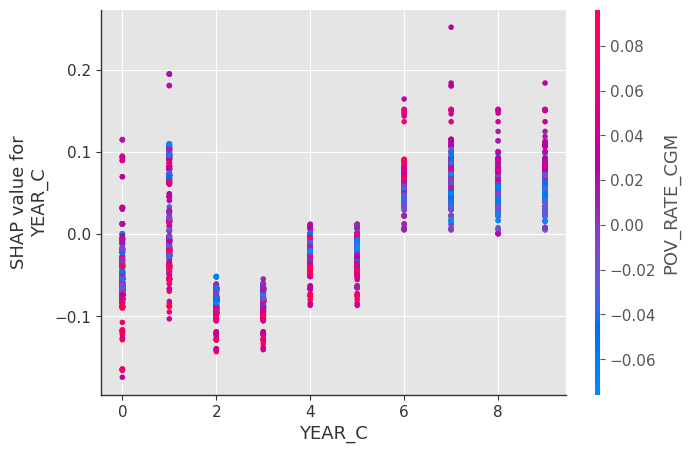

Feature: POPULATION_CWC1


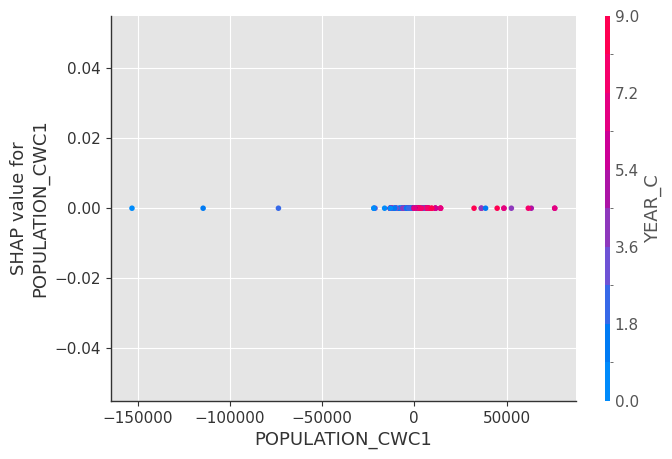

Feature: FACILITIES_CWC1


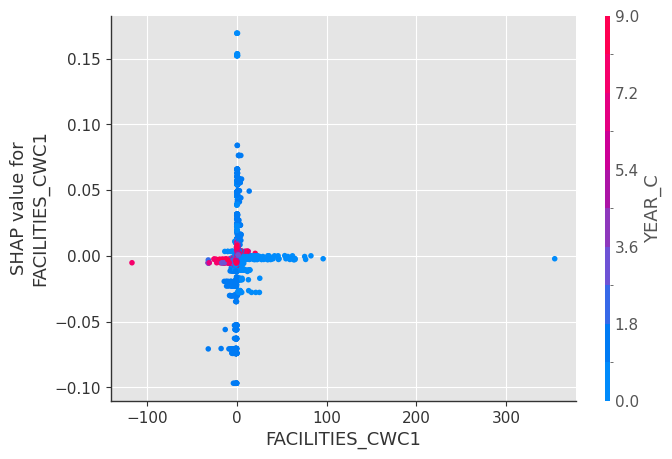

Feature: POPULATION_CWC2


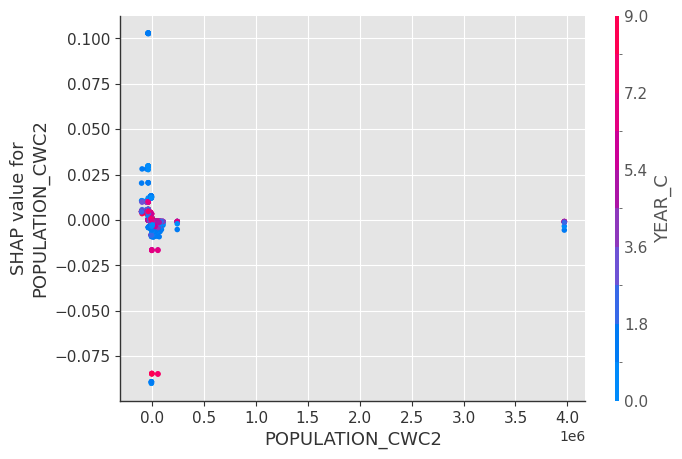

Feature: FACILITIES_CWC2


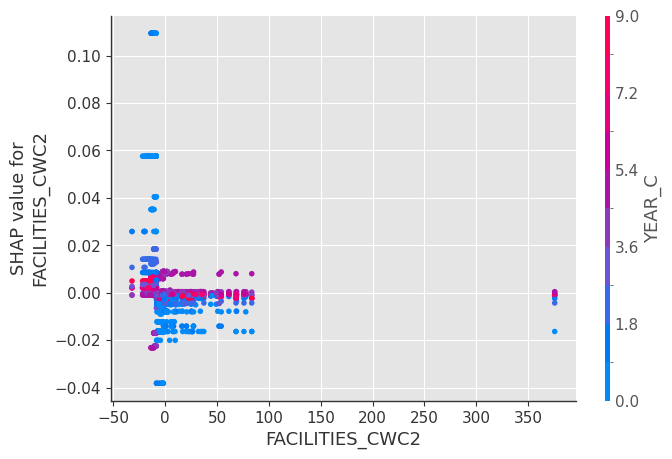

Feature: POPULATION_L3_CGM


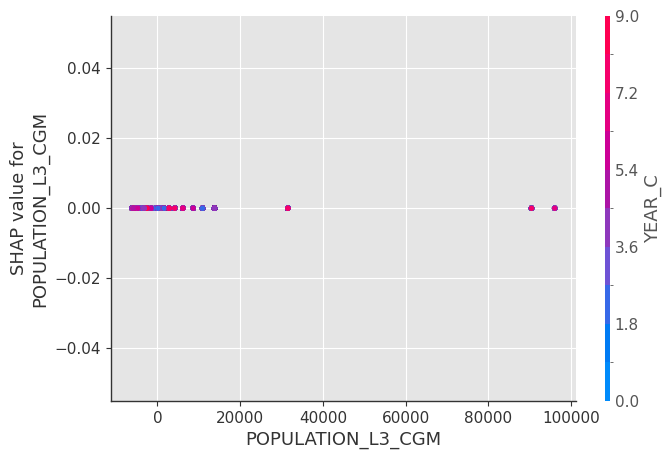

Feature: FACILITIES_L3_CGM


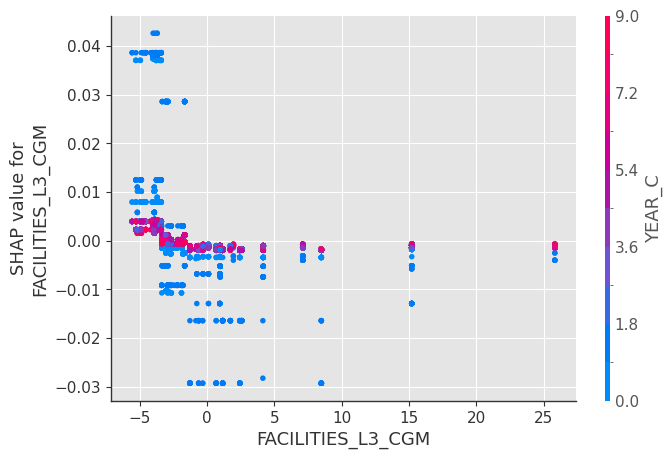

Feature: OWNER_TYPE_D1_CWC1


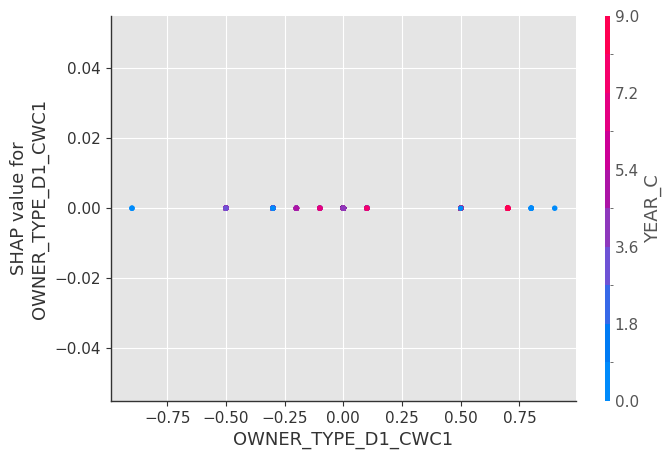

Feature: OWNER_TYPE_D2_CWC1


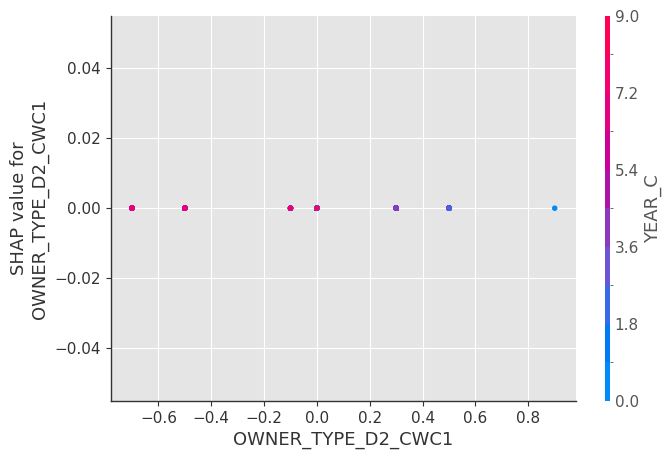

Feature: OWNER_TYPE_D1_CWC2


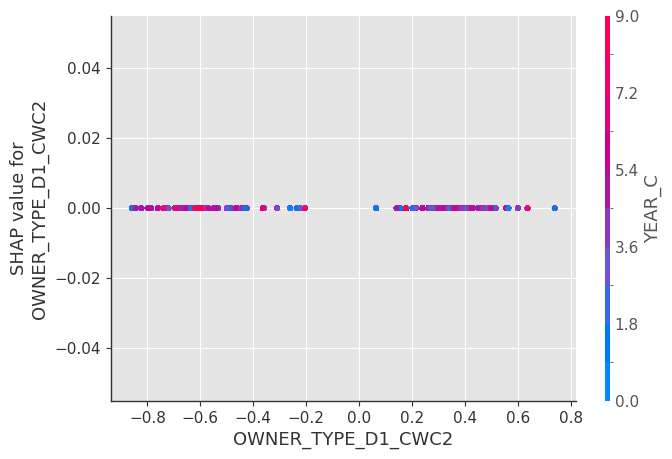

Feature: OWNER_TYPE_D2_CWC2


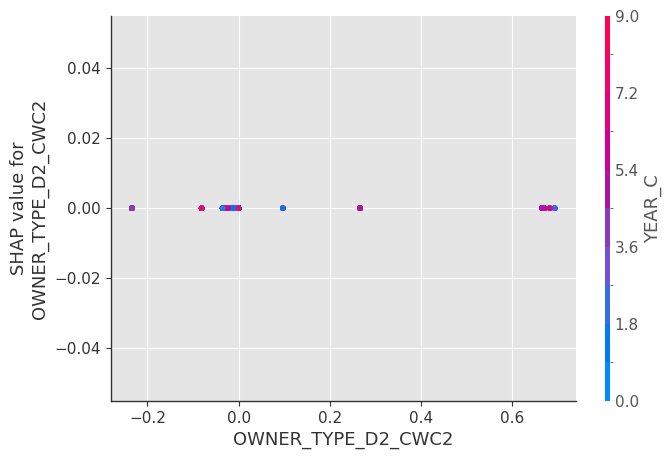

Feature: OWNER_TYPE_D1_L3_CGM


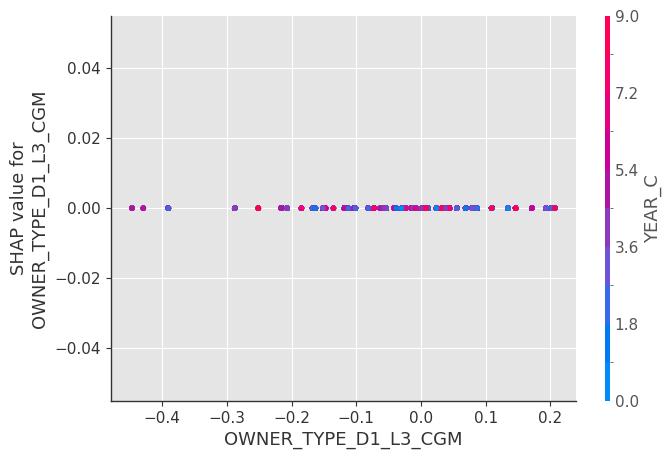

Feature: OWNER_TYPE_D2_L3_CGM


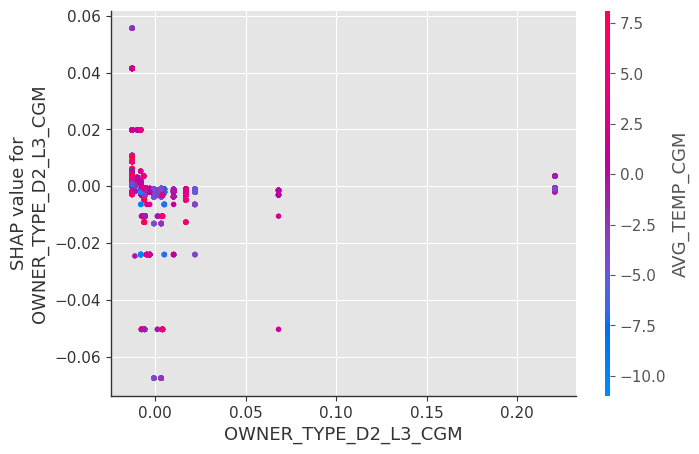

Feature: PWS_TYPE_D1_CWC1


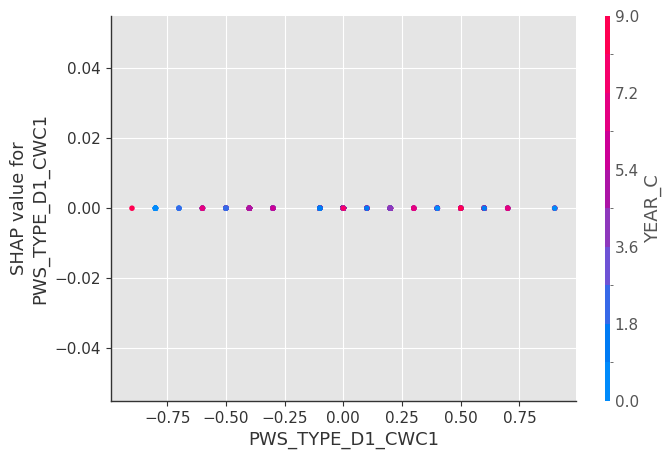

Feature: PWS_TYPE_D2_CWC1


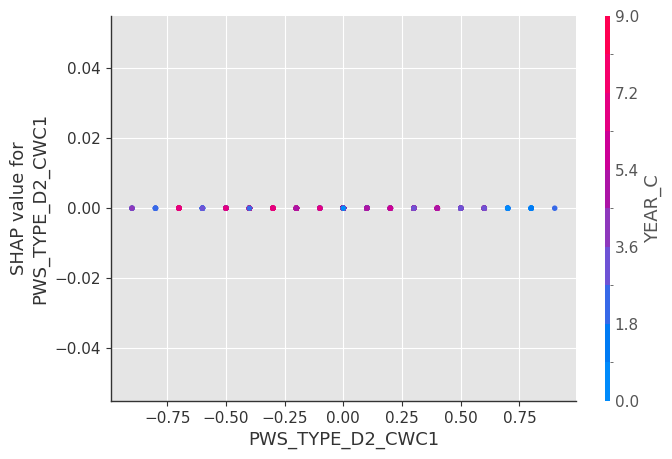

Feature: PWS_TYPE_D1_CWC2


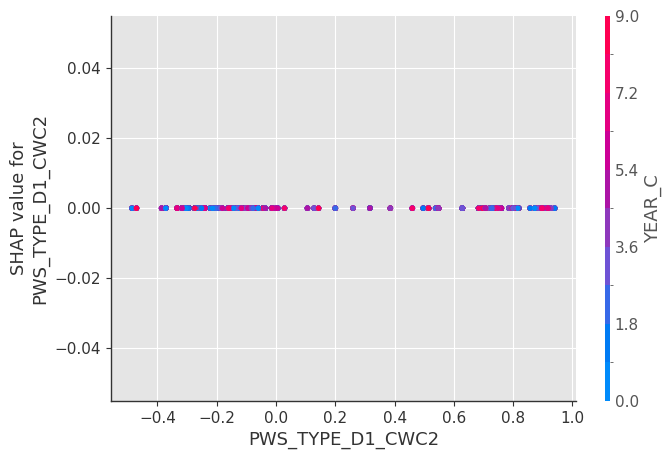

Feature: PWS_TYPE_D2_CWC2


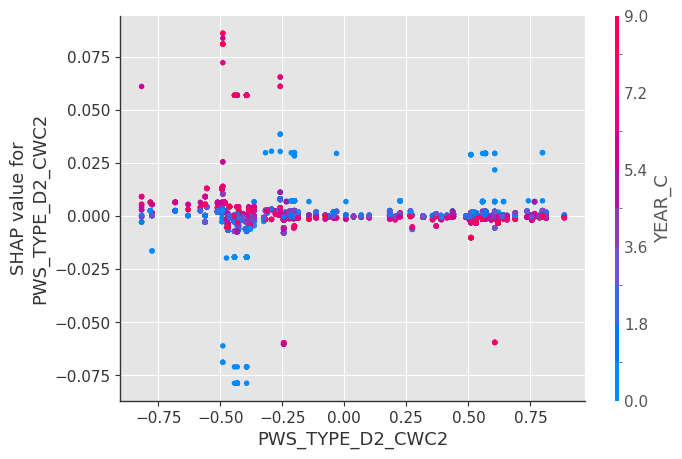

Feature: PWS_TYPE_D1_L3_CGM


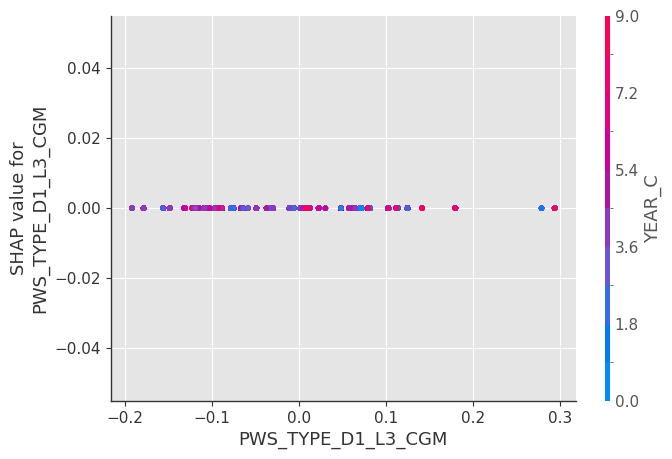

Feature: PWS_TYPE_D2_L3_CGM


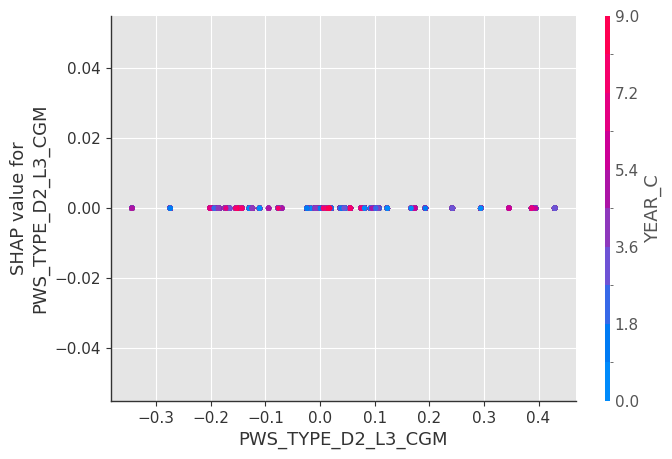

Feature: SOURCE_D1_CWC1


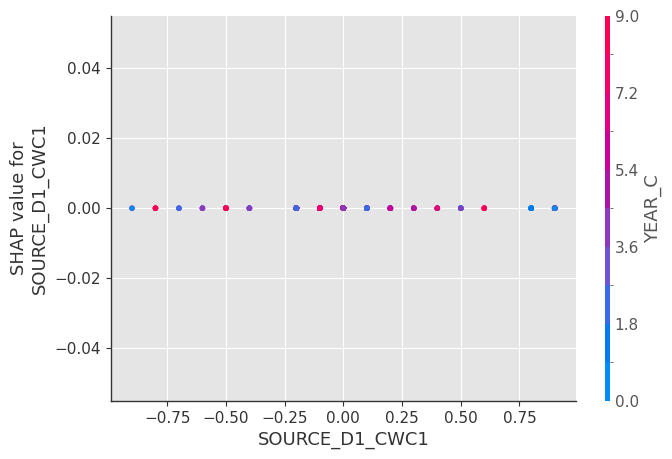

Feature: SOURCE_D2_CWC1


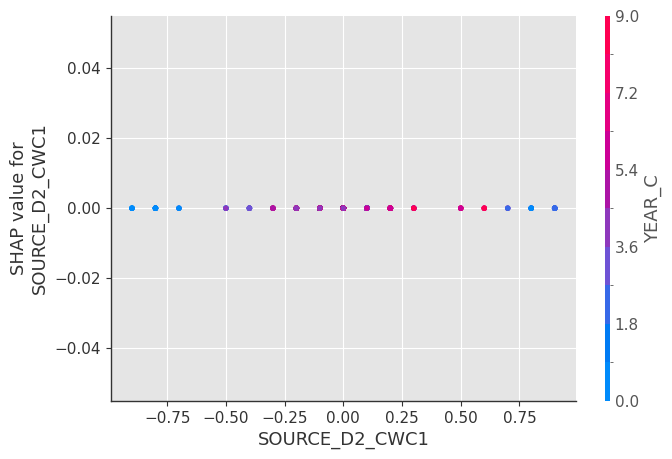

Feature: SOURCE_D1_CWC2


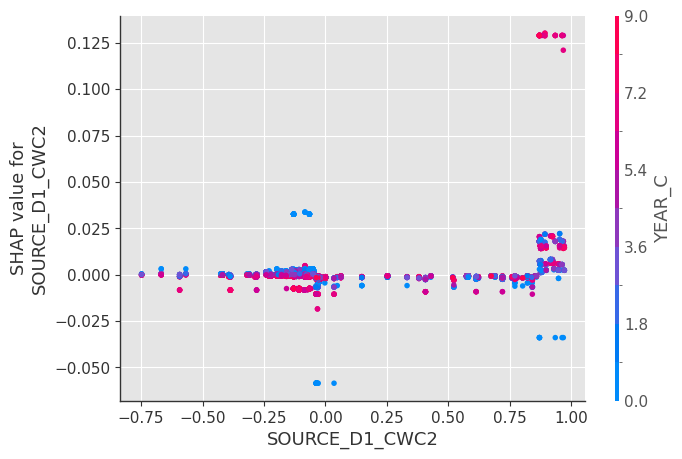

Feature: SOURCE_D2_CWC2


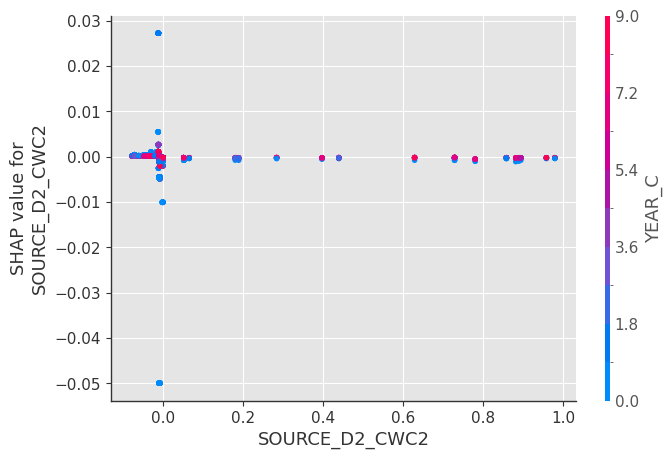

Feature: SOURCE_D1_L3_CGM


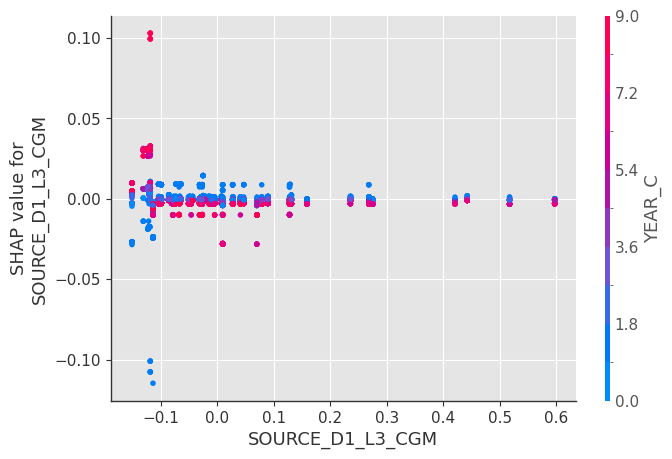

Feature: SOURCE_D2_L3_CGM


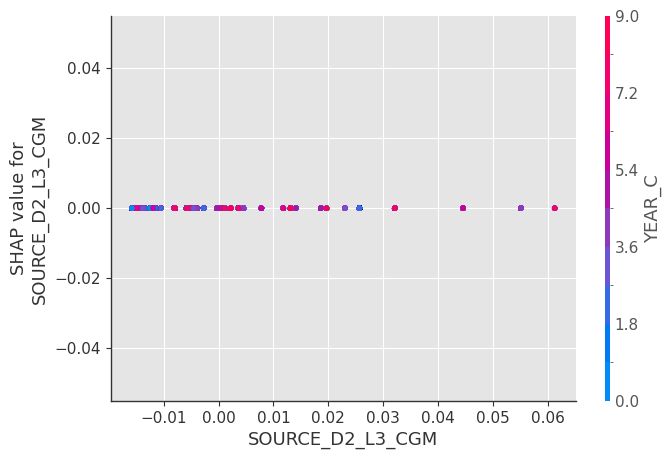

Feature: WHOLESALER_D1_CWC1


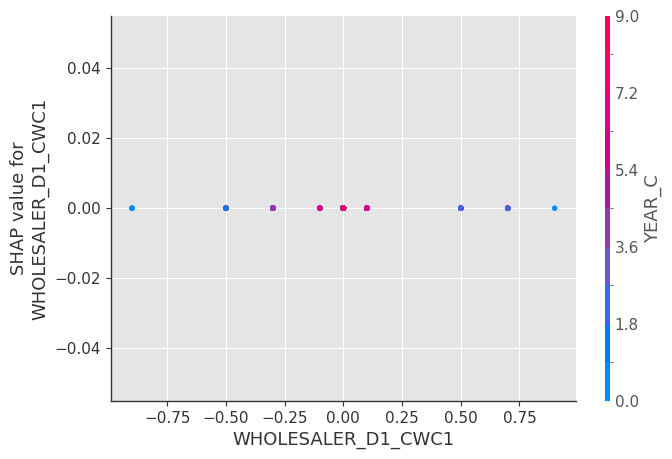

Feature: WHOLESALER_D1_CWC2


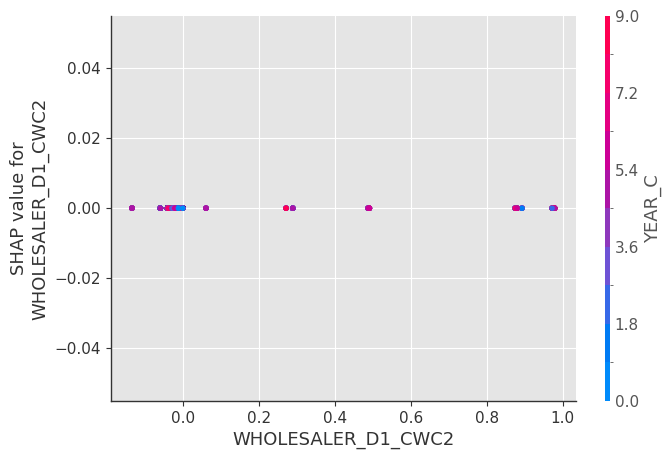

Feature: WHOLESALER_D1_L3_CGM


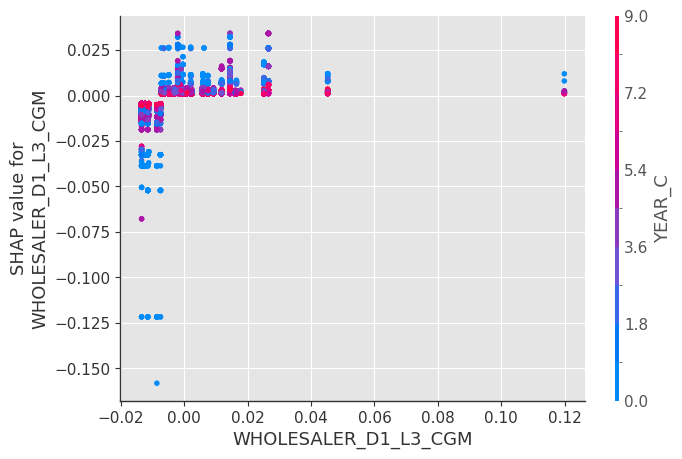

Feature: POV_RATE_CGM


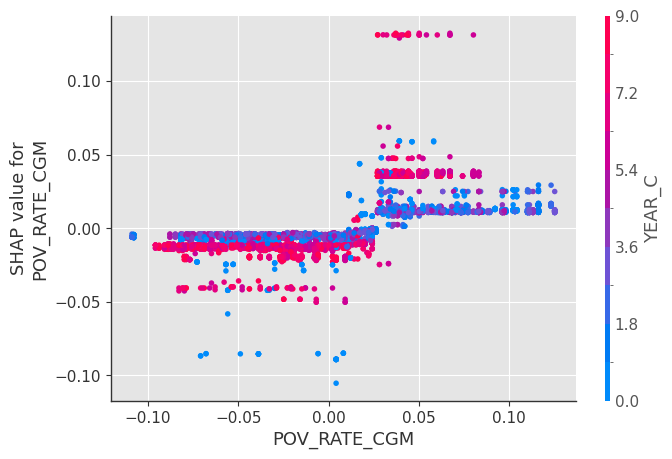

Feature: PERCENT_REP_CGM


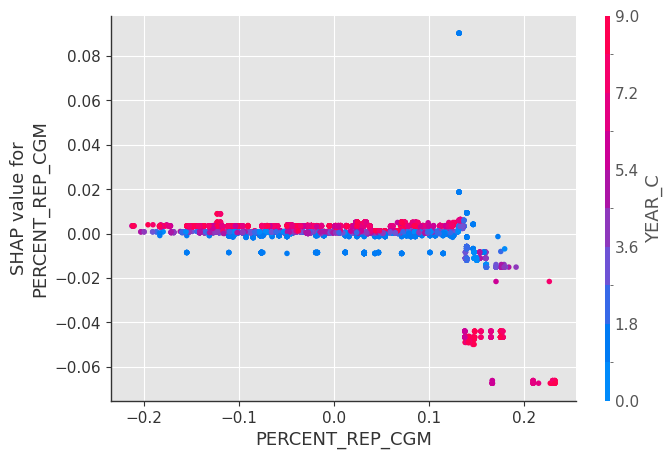

Feature: AVG_PRECIP_CGM


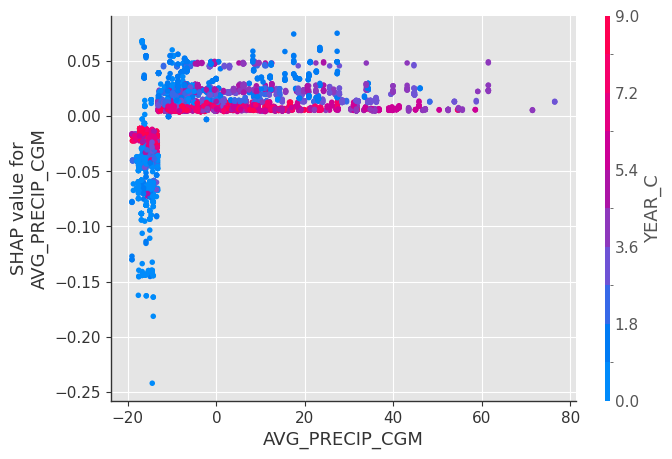

Feature: AVG_TEMP_CGM


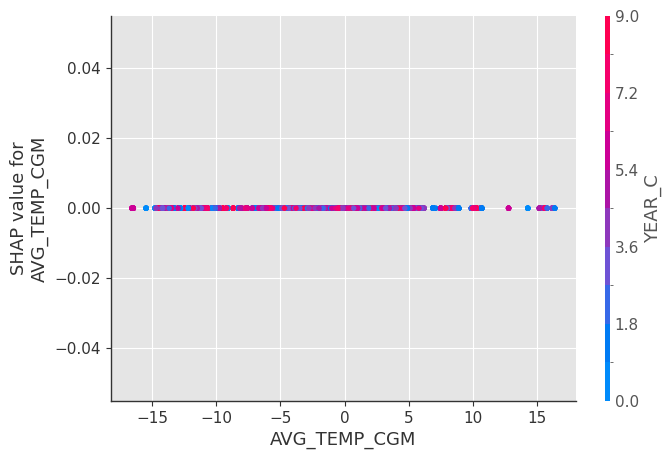

In [44]:
# Create dependence plots
for feature in pred_vars:
    print(f"Feature: {feature}")
    shap.dependence_plot(feature, shap_values_tree, X_test[pred_vars])

In [45]:
# Intialize an Explainer object
explainer = shap.Explainer(
    gpboost_model,
    X_test[pred_vars]
)

# Get SHAP values
shap_values = explainer(X_test[pred_vars], check_additivity=False)

Waterfall Plot for Observation 6562:


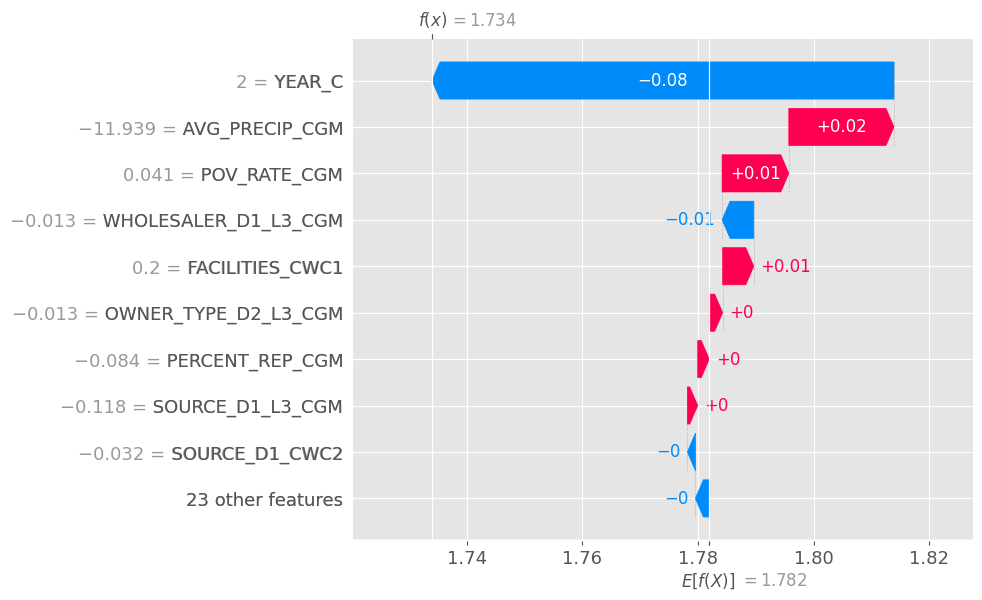

Waterfall Plot for Observation 2444:


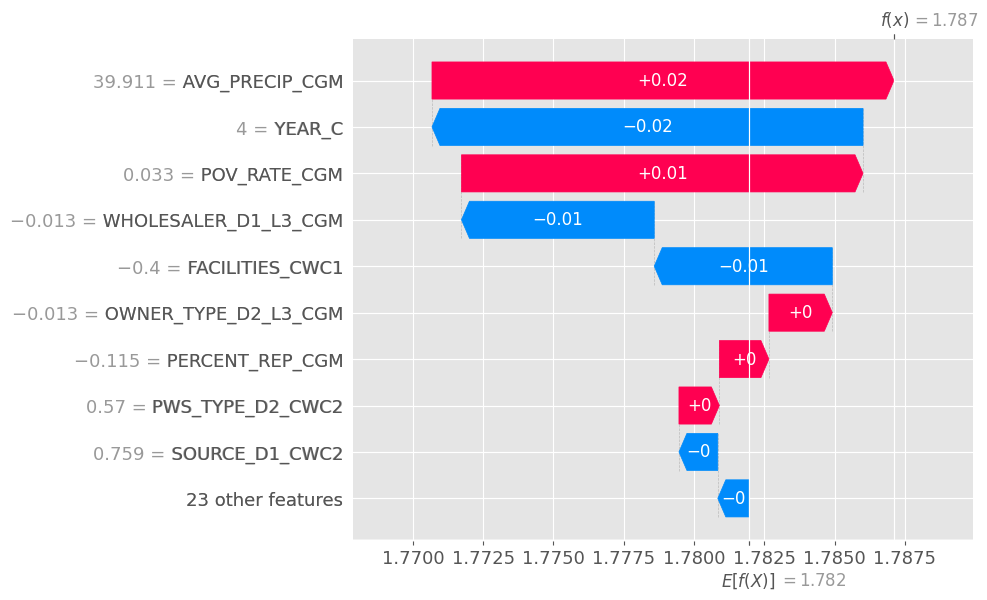

Waterfall Plot for Observation 4549:


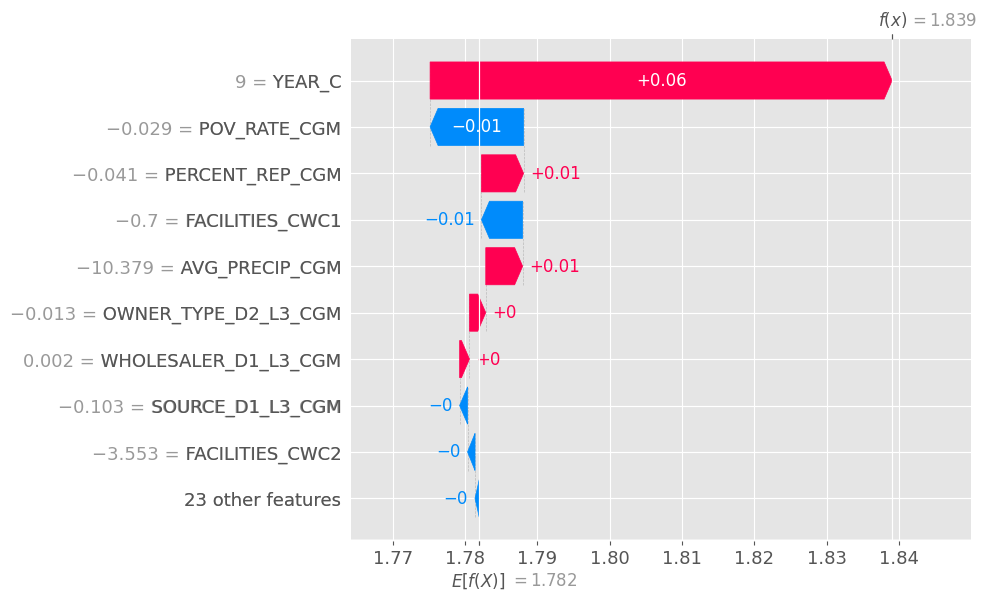

Waterfall Plot for Observation 4951:


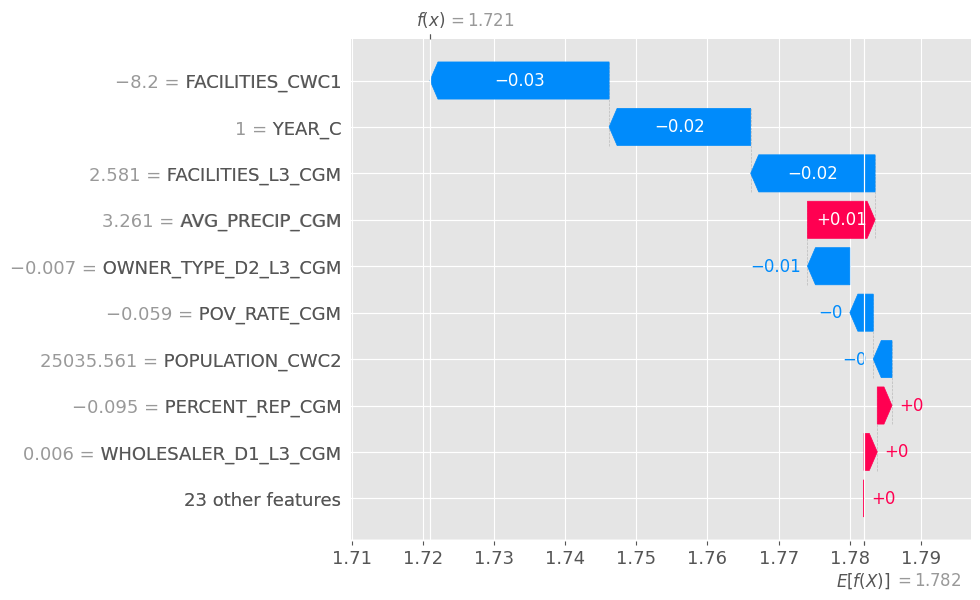

Waterfall Plot for Observation 6277:


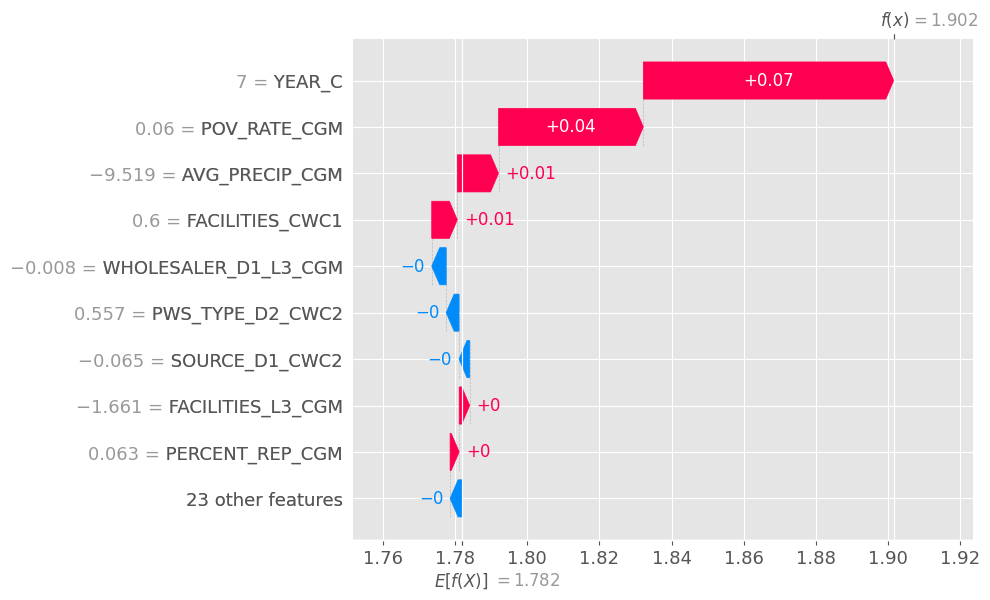

In [46]:
# Select 5 random observations
num_plots = 5
random_obs = random.sample(range(len(shap_values)), num_plots)

# Create waterfall plots for the selected observations
for obs in random_obs:
    print(f"Waterfall Plot for Observation {obs}:")
    shap.plots.waterfall(shap_values[obs])

Beeswarm Plot:


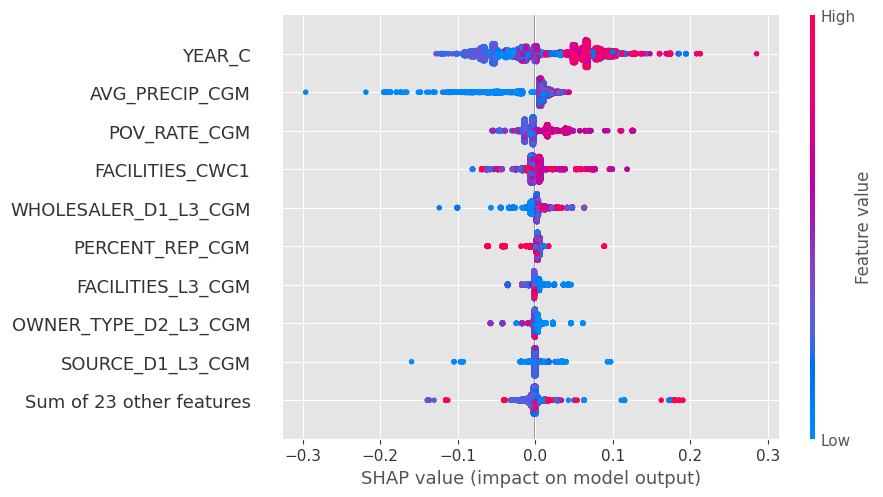

In [47]:
# Beeswarm plot
print(f"Beeswarm Plot:")
shap.plots.beeswarm(shap_values)

Mean SHAP Plot:


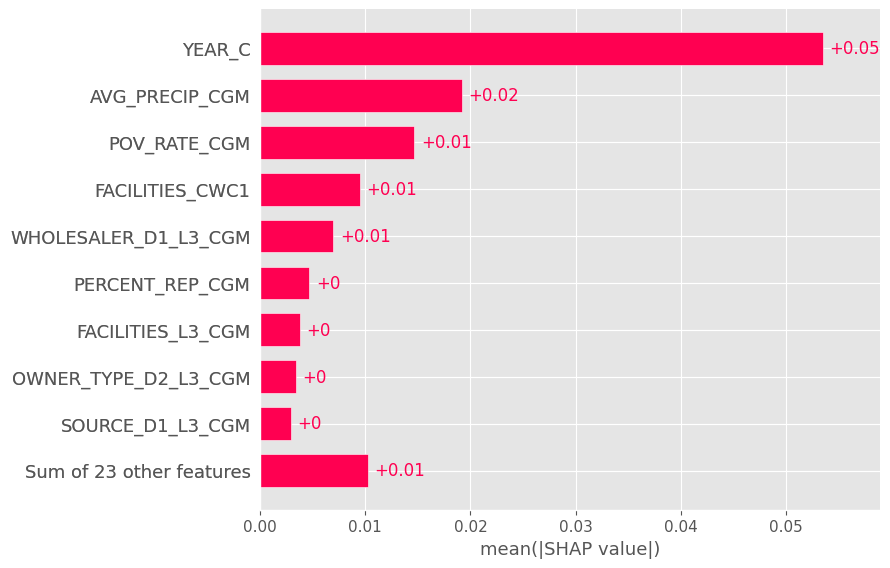

In [48]:
# Mean SHAP plot
print(f"Mean SHAP Plot:")
shap.plots.bar(shap_values)

## Other Information

In [49]:
# Tree DataFrame
tree_df = gpboost_model.trees_to_dataframe()
tree_df.head(10)

tree_index  node_depth node_index left_child right_child parent_index  \
0           0           1       0-S0       0-S1        0-S3         None   
1           0           2       0-S1       0-S2        0-S4         0-S0   
2           0           3       0-S2      0-S19       0-S10         0-S1   
3           0           4      0-S19      0-S20       0-L20         0-S2   
4           0           5      0-S20       0-L0       0-L21        0-S19   
5           0           6       0-L0       None        None        0-S20   
6           0           6      0-L21       None        None        0-S20   
7           0           5      0-L20       None        None        0-S19   
8           0           4      0-S10      0-S11       0-S12         0-S2   
9           0           5      0-S11      0-S14       0-L12        0-S10   

          split_feature    split_gain  threshold decision_type  \
0                YEAR_C  11987.192383   5.500000            <=   
1        AVG_PRECIP_CGM   3649.751953 -13.229184            <=   
2  WHOLESALER_D1_L3_CGM   2213.804688  -0.007352            <=   
3      PWS_TYPE_D2_CWC2    706.486877  -0.322437            <=   
4        SOURCE_D1_CWC2    887.594421  -0.041857            <=   
5                  None           NaN        NaN          None   
6                  None           NaN        NaN          None   
7                  None           NaN        NaN          None   
8       FACILITIES_CWC2   1122.842285  -8.496924            <=   
9                YEAR_C   1901.022583   1.500000            <=   

  missing_direction missing_type     value  weight  count  
0              left         None  1.799483       0  53410  
1              left         None  1.759513   32046  32046  
2              left         None  1.700128    7823   7823  
3              left         None  1.586185    1400   1400  
4              left         None  1.471254     387    387  
5              None         None  1.588481     242    242  
6              None         None  1.275606     145    145  
7              None         None  1.630093    1013   1013  
8              left         None  1.724964    6423   6423  
9              left         None  1.795759    1661   1661

Skipping feature POPULATION_CWC1: Cannot plot split value histogram, because feature POPULATION_CWC1 was not used in splitting
Skipping feature POPULATION_L3_CGM: Cannot plot split value histogram, because feature POPULATION_L3_CGM was not used in splitting
Skipping feature OWNER_TYPE_D1_CWC1: Cannot plot split value histogram, because feature OWNER_TYPE_D1_CWC1 was not used in splitting
Skipping feature OWNER_TYPE_D2_CWC1: Cannot plot split value histogram, because feature OWNER_TYPE_D2_CWC1 was not used in splitting
Skipping feature OWNER_TYPE_D1_CWC2: Cannot plot split value histogram, because feature OWNER_TYPE_D1_CWC2 was not used in splitting
Skipping feature OWNER_TYPE_D2_CWC2: Cannot plot split value histogram, because feature OWNER_TYPE_D2_CWC2 was not used in splitting
Skipping feature OWNER_TYPE_D1_L3_CGM: Cannot plot split value histogram, because feature OWNER_TYPE_D1_L3_CGM was not used in splitting
Skipping feature PWS_TYPE_D1_CWC1: Cannot plot split value histogram, bec

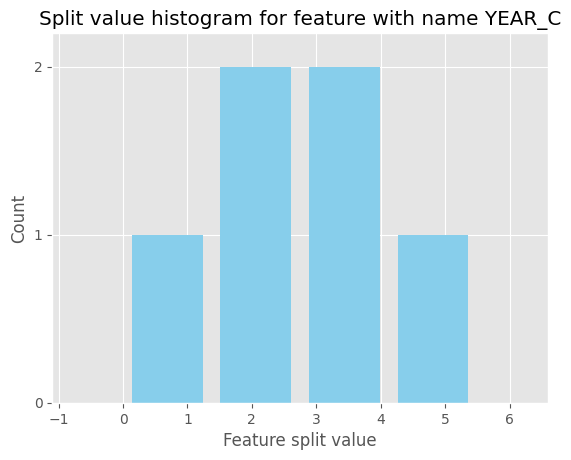

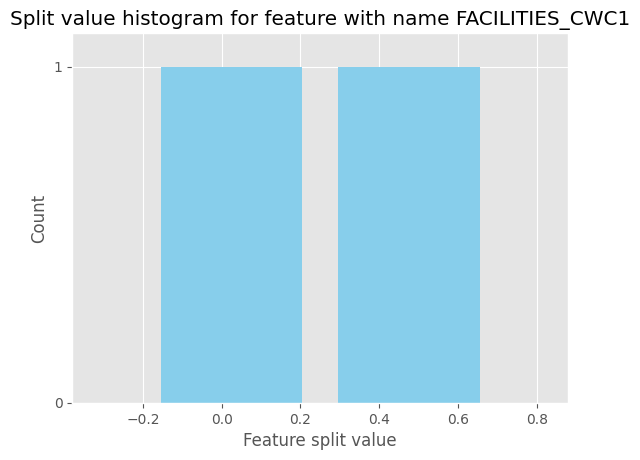

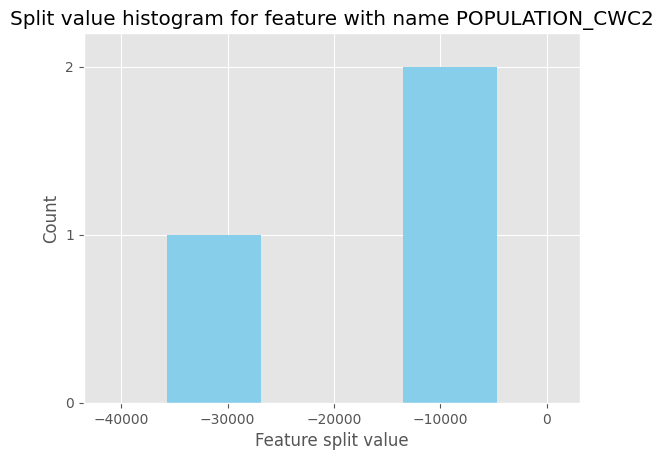

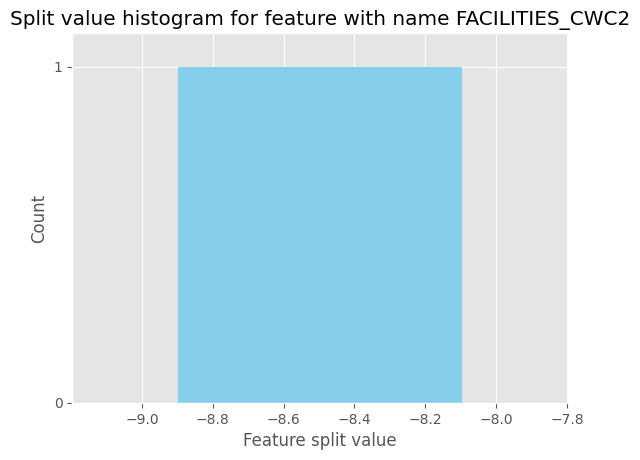

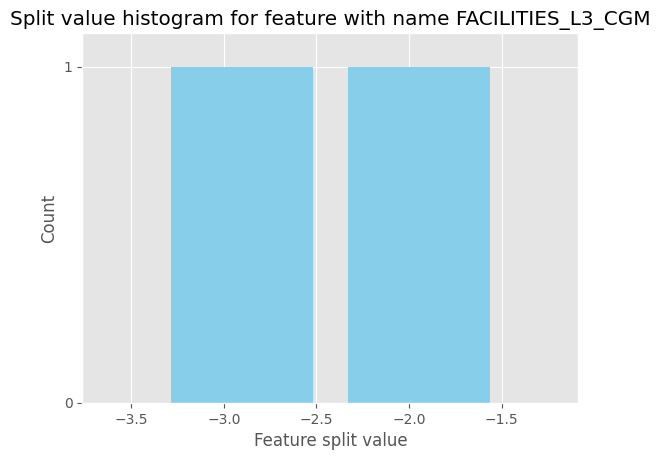

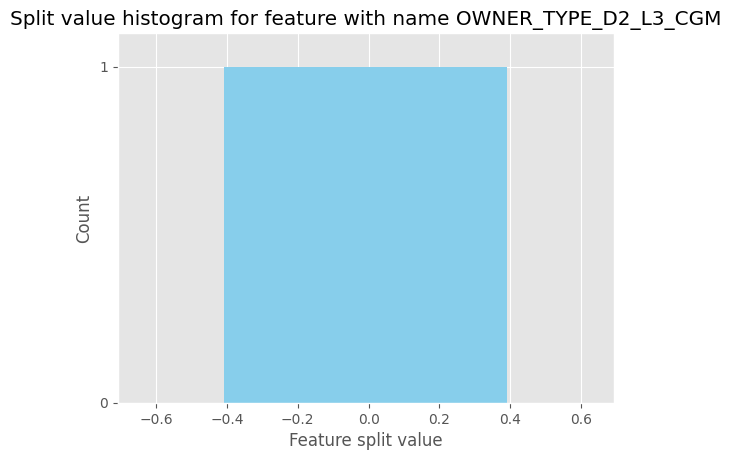

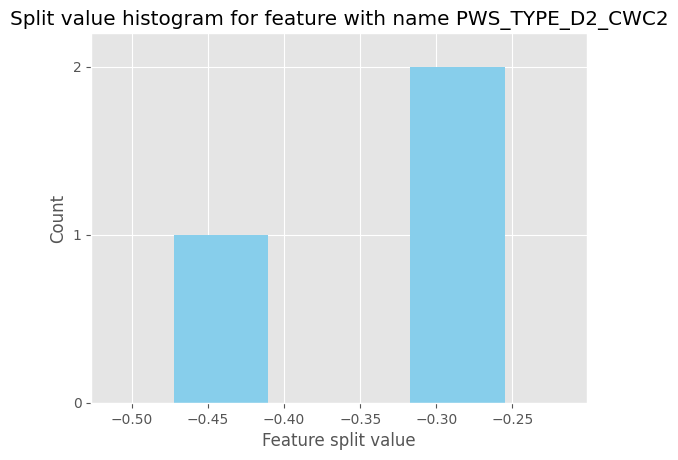

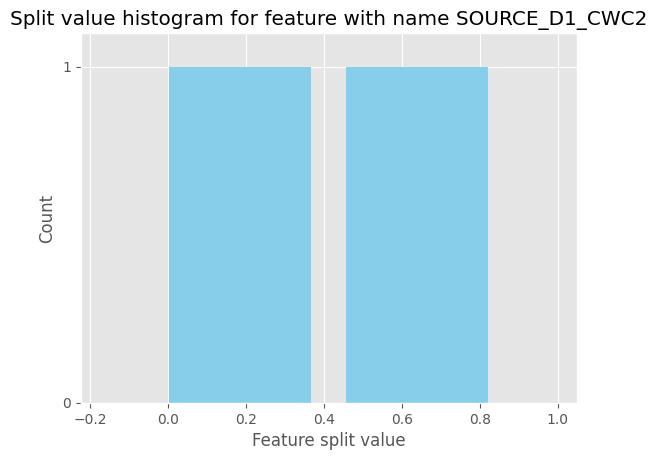

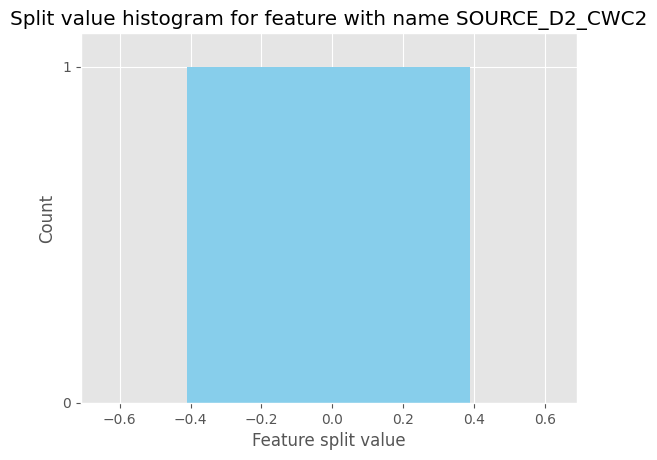

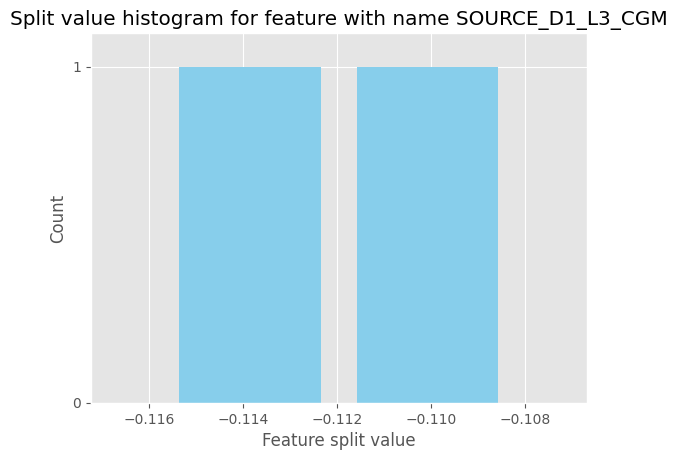

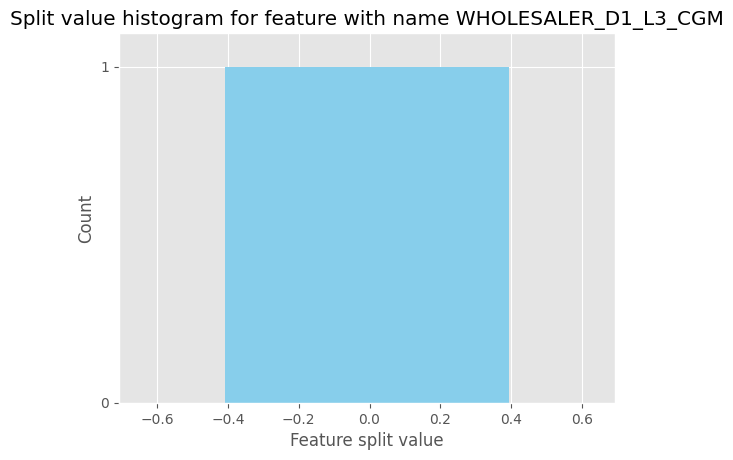

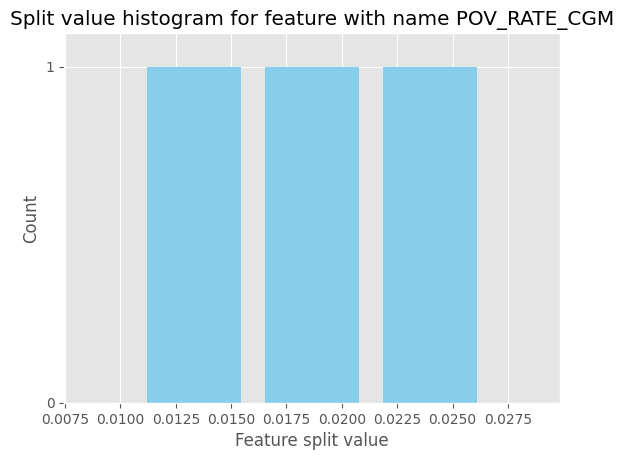

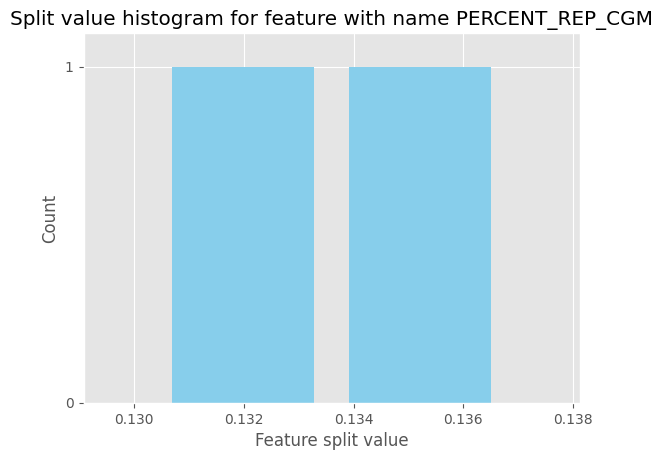

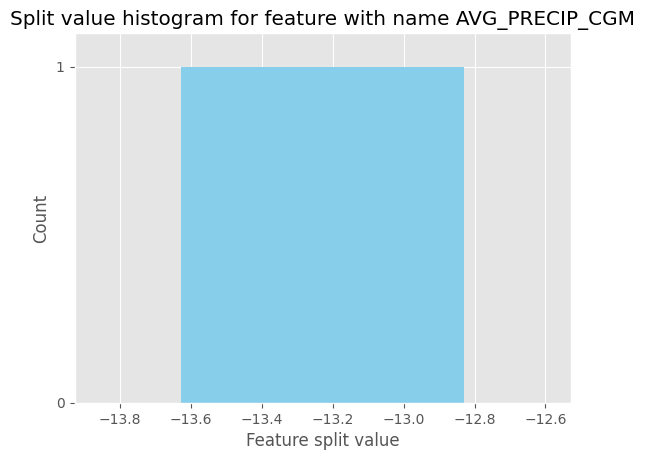

In [50]:
# Plot split value histogram
for i, feature in enumerate(pred_vars):
    try:
        split_value_hist = gpb.plot_split_value_histogram(gpboost_model, feature, color='skyblue')
    except ValueError as e:
        print(f"Skipping feature {feature}: {str(e)}")
        continue

In [51]:
# Tree digraph
num_trees = gpboost_model.num_trees()
max_retries = 5

if num_trees > 0:
    success = False
    for attempt in range(max_retries):
        try:
            tree_index = np.random.randint(0, num_trees)
            tree_digraph = gpb.create_tree_digraph(
                gpboost_model,
                tree_index=tree_index,
                orientation='vertical'
            )
            print(f"Tree digraph for tree {tree_index}:")
            display(tree_digraph)
            success = True
            break
        except IndexError:
            print(f"Retry {attempt + 1}/{max_retries}: Selected tree index {tree_index} is out of range.")

    if not success:
        print("Failed to create a tree digraph after multiple attempts.")
else:
    print("The model has no trees.")

Retry 1/5: Selected tree index 29 is out of range.
Retry 2/5: Selected tree index 35 is out of range.
Retry 3/5: Selected tree index 34 is out of range.
Retry 4/5: Selected tree index 31 is out of range.
Retry 5/5: Selected tree index 26 is out of range.
Failed to create a tree digraph after multiple attempts.


<Axes: >

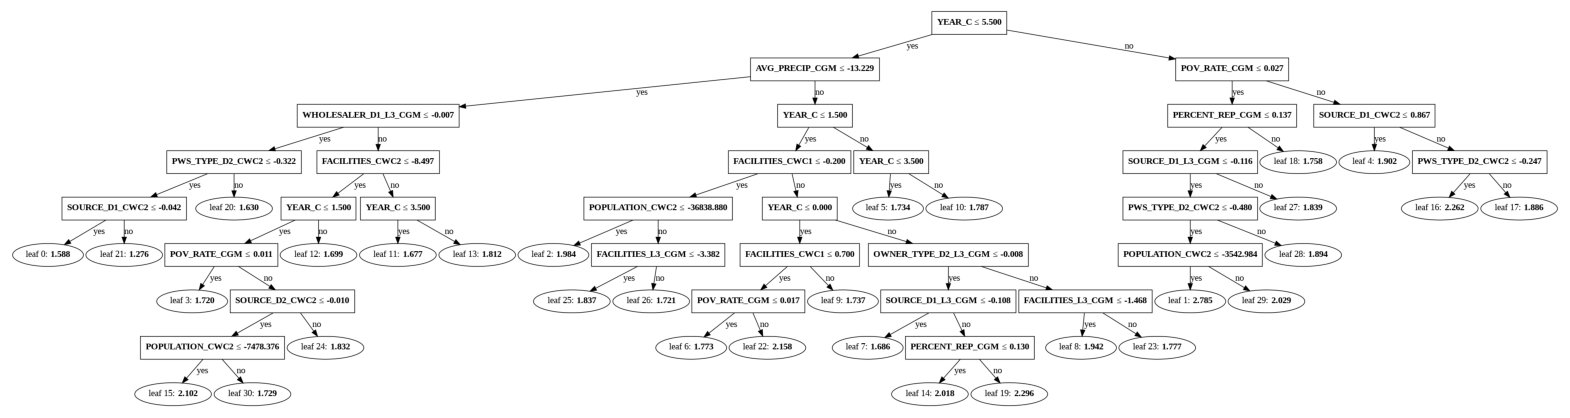

In [52]:
# Tree plot
tree_plot = gpb.plot_tree(
    gpboost_model,
    orientation='vertical',
    figsize=(20, 8)
)
tree_plot

# LightGBM

In [58]:
# Define the columns to convert
categorical_columns = ['PWS_ID', 'COUNTY']

# Convert object types to categorical for all datasets
for dataset in [X_train, X_val, X_test]:
    for col in categorical_columns:
        dataset.loc[:, col] = dataset[col].astype('category')

print(X_train['PWS_ID'].dtype)
print(X_train['COUNTY'].dtype)

category
category


In [59]:
# LightGBM datasets
train_ds_lgb = lgb.Dataset(
    data=X_train[pred_vars + group_vars],
    label=y_train,
    categorical_feature=group_vars
)

# Create GPBoost validation dataset
val_ds_lgb = lgb.Dataset(
    data=X_val[pred_vars + group_vars],
    label=y_val,
    categorical_feature=group_vars,
    reference=train_ds_lgb
)

In [60]:
# Start timer
start_time = time.time()

# Train GPBoost model
lightgbm_model = lgb.train(
    params=params,
    train_set=train_ds_lgb,
    valid_sets=[val_ds_lgb],
    valid_names=['val_lgb']
)

# Print best iteration and score
print(f"Best iteration: {lightgbm_model.best_iteration}")
print(f"Best score: {lightgbm_model.best_score}")

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8996
[LightGBM] [Info] Number of data points in the train set: 53410, number of used features: 34
[LightGBM] [Info] Start training from score 9.827654
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	val_lgb's l2: 140.881
Best iteration: 98
Best score: defaultdict(<class 'collections.OrderedDict'>, {'val_lgb': OrderedDict([('l2', 140.88063405065594)])})
Elapsed time: 1.83547043800354 seconds


In [61]:
# Get predictions on the test set
test_pred_lgb = lightgbm_model.predict(
    data=X_test[pred_vars + group_vars],
    categorical_feature=group_vars
)

# Evaluate performance on the test set
test_rmse_lgb = np.sqrt(np.mean((y_test - test_pred_lgb)**2))
print(f"Test RMSE: {test_rmse_lgb:.4f}")

Test RMSE: 13.3789


In [62]:
# Define feature mapping
lightgbm_feature_mapping = {
    'PWS_ID': "Water System ID",
    'COUNTY': "County Served",
    'YEAR_C': "Year (Centered)",
    'POPULATION_CWC1': "Population (CWC-1)",
    'FACILITIES_CWC1': "Facilities (CWC-1)",
    'POPULATION_CWC2': "Population (CWC-2)",
    'FACILITIES_CWC2': "Facilities (CWC-2)",
    'POPULATION_L3_CGM': "Population (CGM-3)",
    'FACILITIES_L3_CGM': "Facilities (CGM-3)",
    'OWNER_TYPE_D1_CWC1': "Owner: Private (CWC-1)",
    'OWNER_TYPE_D2_CWC1': "Owner: PPP (CWC-1)",
    'OWNER_TYPE_D1_CWC2': "Owner: Private (CWC-2)",
    'OWNER_TYPE_D2_CWC2': "Owner: PPP (CWC-2)",
    'OWNER_TYPE_D1_L3_CGM': "Owner: Private (CGM-3)",
    'OWNER_TYPE_D2_L3_CGM': "Owner: PPP (CGM-3)",
    'PWS_TYPE_D1_CWC1': "Servicer: NTNCWS (CWC-1)",
    'PWS_TYPE_D2_CWC1': "Servicer: TNCWS (CWC-1)",
    'PWS_TYPE_D1_CWC2': "Servicer: NTNCWS (CWC-2)",
    'PWS_TYPE_D2_CWC2': "Servicer: TNCWS (CWC-2)",
    'PWS_TYPE_D1_L3_CGM': "Servicer: NTNCWS (CGM-3)",
    'PWS_TYPE_D2_L3_CGM': "Servicer: TNCWS (CGM-3)",
    'SOURCE_D1_CWC1': "Source: Surface (CWC-1)",
    'SOURCE_D2_CWC1': "Source: Unknown (CWC-1)",
    'SOURCE_D1_CWC2': "Source: Surface (CWC-2)",
    'SOURCE_D2_CWC2': "Source: Unknown (CWC-2)",
    'SOURCE_D1_L3_CGM': "Source: Surface (CGM-3)",
    'SOURCE_D2_L3_CGM': "Source: Unknown (CGM-3)",
    'WHOLESALER_D1_CWC1': "Wholesaler: Yes (CWC-1)",
    'WHOLESALER_D1_CWC2': "Wholesaler: Yes (CWC-2)",
    'WHOLESALER_D1_L3_CGM': "Wholesaler: Yes (CGM-3)",
    'POV_RATE_CGM': "Poverty Rate (CGM-3)",
    'PERCENT_REP_CGM': "Pct Republican (CGM-3)",
    'AVG_PRECIP_CGM': "Precipitation (CGM-3)",
    'AVG_TEMP_CGM': "Temperature (CGM-3)"
}

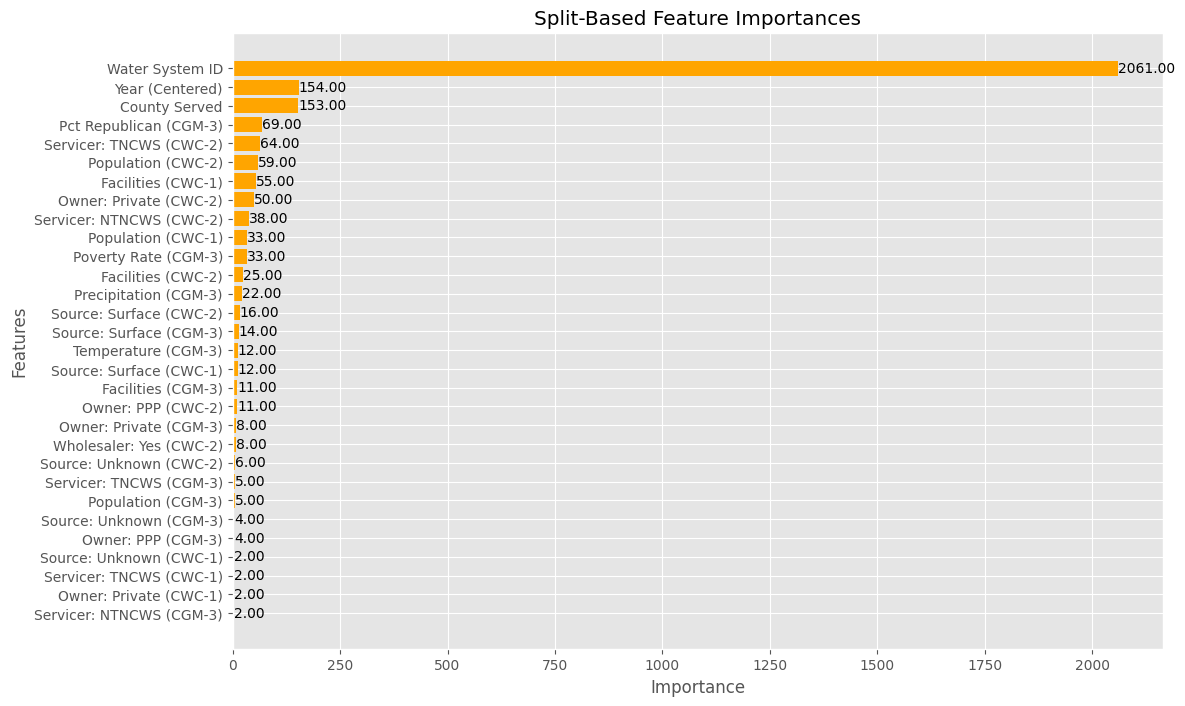

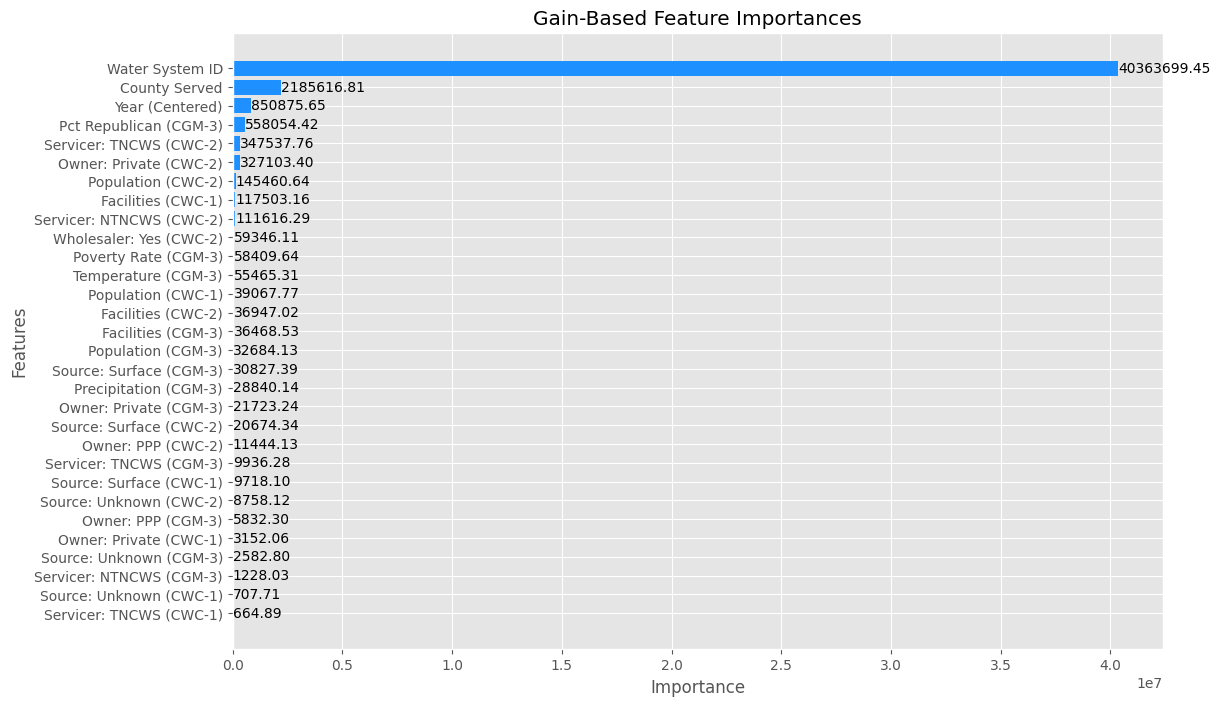

In [63]:
# Get the feature importances for split
split_importance_df_lgb = pd.DataFrame({
    'feature': lightgbm_model.feature_name(),
    'importance': lightgbm_model.feature_importance(importance_type='split')
})

# Filter out zero importance features
split_importance_df_lgb = split_importance_df_lgb[split_importance_df_lgb['importance'] > 0]

# Map the feature names
split_importance_df_lgb['mapped_feature'] = split_importance_df_lgb['feature'].map(lightgbm_feature_mapping).fillna(split_importance_df_lgb['feature'])

# Sort by importance
split_importance_df_lgb = split_importance_df_lgb.sort_values(by='importance', ascending=False)

# Plot the sorted feature importances for split
plt.figure(figsize=(12, 8))
bars = plt.barh(split_importance_df_lgb['mapped_feature'], split_importance_df_lgb['importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Split-Based Feature Importances')
plt.gca().invert_yaxis()

# Add importance values to the bars
for bar in bars:
    plt.gca().text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}',
                   va='center', ha='left', color='black', fontsize=10)

plt.show()

# Get the feature importances for gain
gain_importance_df_lgb = pd.DataFrame({
    'feature': lightgbm_model.feature_name(),
    'importance': lightgbm_model.feature_importance(importance_type='gain')
})

# Filter out zero importance features
gain_importance_df_lgb = gain_importance_df_lgb[gain_importance_df_lgb['importance'] > 0]

# Map the feature names
gain_importance_df_lgb['mapped_feature'] = gain_importance_df_lgb['feature'].map(lightgbm_feature_mapping).fillna(gain_importance_df_lgb['feature'])

# Sort by importance
gain_importance_df_lgb = gain_importance_df_lgb.sort_values(by='importance', ascending=False)

# Plot the sorted feature importances for gain
plt.figure(figsize=(12, 8))
bars = plt.barh(gain_importance_df_lgb['mapped_feature'], gain_importance_df_lgb['importance'], color='dodgerblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Gain-Based Feature Importances')
plt.gca().invert_yaxis()

# Add importance values to the bars
for bar in bars:
    plt.gca().text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}',
                   va='center', ha='left', color='black', fontsize=10)

plt.show()